# Smart Absensi Berbasis Wajah

Sistem absensi realtime menggunakan face recognition dengan Python.

---

## Fitur Utama:
1. **Registrasi Wajah** - Mendaftarkan wajah baru ke sistem
2. **Absensi Realtime** - Deteksi dan pencatatan absensi otomatis
3. **Visualisasi Data** - Melihat rekap absensi

---


## A. KONFIGURASI AWAL

### Import Library dan Cek Versi


In [1]:
# Import semua library yang diperlukan
import cv2
import face_recognition
import numpy as np
import pandas as pd
import pickle
import os
from datetime import datetime
import time

# Cek versi library
print("=" * 50)
print("VERSI LIBRARY")
print("=" * 50)
print(f"OpenCV: {cv2.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Face Recognition: {face_recognition.__version__}")
print("=" * 50)
print("✓ Semua library berhasil diimport!")


C:\Users\DELL\miniconda3\envs\vis-env\Lib\site-packages\face_recognition_models\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


VERSI LIBRARY
OpenCV: 4.12.0
NumPy: 2.4.1
Pandas: 2.3.3
Face Recognition: 1.2.3
✓ Semua library berhasil diimport!


In [2]:
# Import library untuk visualisasi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML

# Set matplotlib untuk menampilkan plot di notebook
%matplotlib inline

print("✓ Library visualisasi berhasil diimport!")
print("✓ Siap untuk menampilkan before/after preprocessing!")

✓ Library visualisasi berhasil diimport!
✓ Siap untuk menampilkan before/after preprocessing!


---

## A.1. FUNGSI VISUALISASI PREPROCESSING

Fungsi-fungsi helper untuk memvisualisasikan setiap tahap preprocessing.

In [3]:
def visualize_before_after(img_before, img_after, title_before="Before", title_after="After", figsize=(12, 5)):
    """
    Menampilkan perbandingan gambar before dan after
    
    Parameters:
    - img_before: Gambar sebelum proses (numpy array atau PIL Image)
    - img_after: Gambar setelah proses (numpy array atau PIL Image)
    - title_before: Judul untuk gambar before
    - title_after: Judul untuk gambar after
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Convert ke RGB jika BGR (OpenCV)
    if isinstance(img_before, np.ndarray) and len(img_before.shape) == 3:
        if img_before.shape[2] == 3:
            img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)
    
    if isinstance(img_after, np.ndarray) and len(img_after.shape) == 3:
        if img_after.shape[2] == 3:
            img_after = cv2.cvtColor(img_after, cv2.COLOR_BGR2RGB)
    
    # Plot before
    axes[0].imshow(img_before)
    axes[0].set_title(f"{title_before}\nShape: {img_before.shape if isinstance(img_before, np.ndarray) else img_before.size}", 
                     fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Plot after
    axes[1].imshow(img_after)
    axes[1].set_title(f"{title_after}\nShape: {img_after.shape if isinstance(img_after, np.ndarray) else img_after.size}", 
                     fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_face_detection(image, face_locations, title="Face Detection Result"):
    """
    Visualisasi hasil deteksi wajah dengan kotak di sekitar wajah
    
    Parameters:
    - image: Gambar asli (numpy array atau PIL Image)
    - face_locations: List of (top, right, bottom, left)
    - title: Judul visualisasi
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    # Convert ke RGB jika BGR
    if isinstance(image, np.ndarray) and len(image.shape) == 3 and image.shape[2] == 3:
        display_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        display_img = image
    
    ax.imshow(display_img)
    ax.set_title(f"{title}\n{len(face_locations)} wajah terdeteksi", fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Gambar kotak untuk setiap wajah
    for i, (top, right, bottom, left) in enumerate(face_locations):
        width = right - left
        height = bottom - top
        
        # Kotak hijau di sekitar wajah
        rect = patches.Rectangle((left, top), width, height, 
                                 linewidth=3, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        
        # Label nomor wajah
        ax.text(left, top - 10, f'Face {i+1}', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lime', alpha=0.7),
               fontsize=12, fontweight='bold', color='black')
    
    plt.tight_layout()
    plt.show()

def visualize_encoding_heatmap(encoding, title="Face Encoding (128D Vector)"):
    """
    Visualisasi face encoding sebagai heatmap
    
    Parameters:
    - encoding: Face encoding numpy array (128D)
    - title: Judul visualisasi
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))
    
    # Plot 1: Line plot untuk melihat nilai encoding
    axes[0].plot(encoding, linewidth=1.5, color='blue')
    axes[0].set_title(f"{title} - Line Plot", fontsize=12, fontweight='bold')
    axes[0].set_xlabel("Dimension (0-127)", fontsize=10)
    axes[0].set_ylabel("Value", fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Zero line')
    axes[0].legend()
    
    # Plot 2: Heatmap untuk melihat pola encoding
    axes[1].imshow(encoding.reshape(1, -1), cmap='coolwarm', aspect='auto')
    axes[1].set_title("Heatmap Representation", fontsize=12, fontweight='bold')
    axes[1].set_xlabel("Dimension (0-127)", fontsize=10)
    axes[1].set_yticks([])
    
    # Colorbar
    cbar = plt.colorbar(axes[1].imshow(encoding.reshape(1, -1), cmap='coolwarm', aspect='auto'), 
                       ax=axes[1], orientation='horizontal', pad=0.1)
    cbar.set_label('Encoding Value', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistik encoding
    print("=" * 60)
    print("STATISTIK FACE ENCODING:")
    print("=" * 60)
    print(f"Dimensi        : {len(encoding)}D")
    print(f"Min value      : {encoding.min():.4f}")
    print(f"Max value      : {encoding.max():.4f}")
    print(f"Mean           : {encoding.mean():.4f}")
    print(f"Std deviation  : {encoding.std():.4f}")
    print(f"Nilai positif  : {(encoding > 0).sum()} ({(encoding > 0).sum()/len(encoding)*100:.1f}%)")
    print(f"Nilai negatif  : {(encoding < 0).sum()} ({(encoding < 0).sum()/len(encoding)*100:.1f}%)")
    print("=" * 60)

def visualize_face_comparison(img1, img2, encoding1, encoding2, distance, title="Face Comparison"):
    """
    Visualisasi perbandingan 2 wajah dengan encoding dan distance
    
    Parameters:
    - img1, img2: Gambar wajah
    - encoding1, encoding2: Face encodings
    - distance: Face distance
    - title: Judul visualisasi
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # Convert ke RGB jika BGR
    if isinstance(img1, np.ndarray) and len(img1.shape) == 3 and img1.shape[2] == 3:
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    if isinstance(img2, np.ndarray) and len(img2.shape) == 3 and img2.shape[2] == 3:
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Gambar 1
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img1)
    ax1.set_title("Face 1", fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Gambar 2
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img2)
    ax2.set_title("Face 2", fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Encoding 1 heatmap
    ax3 = fig.add_subplot(gs[1, 0])
    im1 = ax3.imshow(encoding1.reshape(1, -1), cmap='coolwarm', aspect='auto')
    ax3.set_title("Encoding Face 1", fontsize=11, fontweight='bold')
    ax3.set_xlabel("Dimension", fontsize=9)
    ax3.set_yticks([])
    
    # Encoding 2 heatmap
    ax4 = fig.add_subplot(gs[1, 1])
    im2 = ax4.imshow(encoding2.reshape(1, -1), cmap='coolwarm', aspect='auto')
    ax4.set_title("Encoding Face 2", fontsize=11, fontweight='bold')
    ax4.set_xlabel("Dimension", fontsize=9)
    ax4.set_yticks([])
    
    # Difference heatmap
    ax5 = fig.add_subplot(gs[2, :])
    diff = np.abs(encoding1 - encoding2)
    im3 = ax5.imshow(diff.reshape(1, -1), cmap='hot', aspect='auto')
    ax5.set_title(f"Absolute Difference | Distance: {distance:.4f}", fontsize=12, fontweight='bold')
    ax5.set_xlabel("Dimension", fontsize=10)
    ax5.set_yticks([])
    
    # Colorbar untuk difference
    cbar = plt.colorbar(im3, ax=ax5, orientation='horizontal', pad=0.15)
    cbar.set_label('Absolute Difference', fontsize=10)
    
    # Kesimpulan
    confidence = (1 - distance) * 100
    match_status = "MATCH ✓" if distance <= 0.6 else "NOT MATCH ✗"
    color = 'green' if distance <= 0.6 else 'red'
    
    fig.suptitle(f"{title}\n{match_status} | Distance: {distance:.4f} | Confidence: {confidence:.2f}%", 
                fontsize=16, fontweight='bold', color=color, y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print("=" * 70)
    print("HASIL PERBANDINGAN:")
    print("=" * 70)
    print(f"Face Distance      : {distance:.6f}")
    print(f"Confidence         : {confidence:.2f}%")
    print(f"Threshold (0.6)    : {'PASS ✓' if distance <= 0.6 else 'FAIL ✗'}")
    print(f"Status             : {match_status}")
    print(f"Mean Difference    : {diff.mean():.6f}")
    print(f"Max Difference     : {diff.max():.6f}")
    print("=" * 70)

print("✓ Fungsi visualisasi preprocessing berhasil didefinisikan!")
print("✓ Fungsi yang tersedia:")
print("  1. visualize_before_after() - Perbandingan before/after")
print("  2. visualize_face_detection() - Visualisasi deteksi wajah")
print("  3. visualize_encoding_heatmap() - Visualisasi face encoding")
print("  4. visualize_face_comparison() - Perbandingan 2 wajah")

✓ Fungsi visualisasi preprocessing berhasil didefinisikan!
✓ Fungsi yang tersedia:
  1. visualize_before_after() - Perbandingan before/after
  2. visualize_face_detection() - Visualisasi deteksi wajah
  3. visualize_encoding_heatmap() - Visualisasi face encoding
  4. visualize_face_comparison() - Perbandingan 2 wajah


### Inisialisasi Folder dan File


In [4]:
# Buat folder jika belum ada
folders = ['dataset_wajah', 'encodings', 'output']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"✓ Folder '{folder}' dibuat")
    else:
        print(f"✓ Folder '{folder}' sudah ada")

# Buat file absensi.csv jika belum ada
if not os.path.exists('absensi.csv'):
    df = pd.DataFrame(columns=['nama', 'id', 'waktu'])
    df.to_csv('absensi.csv', index=False)
    print("✓ File 'absensi.csv' dibuat")
else:
    print("✓ File 'absensi.csv' sudah ada")

print("\n✓ Inisialisasi selesai!")


✓ Folder 'dataset_wajah' sudah ada
✓ Folder 'encodings' sudah ada
✓ Folder 'output' sudah ada
✓ File 'absensi.csv' sudah ada

✓ Inisialisasi selesai!


### Test Kamera

Fungsi untuk mencari kamera yang tersedia dan menguji apakah kamera berfungsi.


In [5]:
def find_camera():
    """
    Mencari kamera yang tersedia dengan mencoba index 0, 1, dan 2
    Returns: camera index yang berfungsi atau None
    """
    for i in range(3):
        cap = cv2.VideoCapture(i)
        if cap.isOpened():
            print(f"✓ Kamera ditemukan di index {i}")
            return i, cap
        cap.release()
    return None, None

# Test kamera
print("Mencari kamera yang tersedia...")
camera_index, test_cap = find_camera()

if test_cap is None:
    print("\n❌ ERROR: Tidak ada kamera yang terdeteksi!")
    print("Solusi:")
    print("1. Pastikan kamera laptop berfungsi")
    print("2. Pastikan tidak ada aplikasi lain yang menggunakan kamera")
    print("3. Coba restart kernel dan jalankan ulang")
else:
    print("\nTekan 'q' untuk keluar dari preview kamera...\n")
    print("Membuka preview kamera dalam 2 detik...")
    time.sleep(2)
    
    # Tampilkan preview kamera selama 5 detik atau sampai 'q' ditekan
    start_time = time.time()
    frame_count = 0
    
    while True:
        ret, frame = test_cap.read()
        if not ret:
            print("❌ Gagal membaca frame dari kamera")
            break
        
        frame_count += 1
        
        # Tambahkan teks ke frame
        cv2.putText(frame, "TEST KAMERA - Tekan 'q' untuk keluar", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(frame, f"Frame: {frame_count}", 
                    (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        cv2.imshow('Test Kamera', frame)
        
        # Keluar jika 'q' ditekan atau sudah 10 detik
        if cv2.waitKey(1) & 0xFF == ord('q') or (time.time() - start_time) > 10:
            break
    
    # Tutup kamera dengan benar
    test_cap.release()
    cv2.destroyAllWindows()
    
    # Tunggu sebentar untuk memastikan window tertutup
    for i in range(4):
        cv2.waitKey(1)
    
    print(f"\n✓ Test kamera selesai! ({frame_count} frame berhasil dibaca)")
    print(f"✓ Kamera berfungsi dengan baik di index {camera_index}")


Mencari kamera yang tersedia...
✓ Kamera ditemukan di index 0

Tekan 'q' untuk keluar dari preview kamera...

Membuka preview kamera dalam 2 detik...

✓ Test kamera selesai! (259 frame berhasil dibaca)
✓ Kamera berfungsi dengan baik di index 0


---

## A.2. DEMO PREPROCESSING STEP-BY-STEP

Demonstrasi visual setiap tahap preprocessing untuk memahami apa yang terjadi di balik layar.

### 1. Image Resize (Before & After)

DEMO 1: IMAGE RESIZE (OPTIMASI PERFORMA)

📷 Mengambil 1 frame dari kamera...

✓ Kamera ditemukan di index 0
✓ Frame berhasil diambil!

INFORMASI RESIZE:
----------------------------------------------------------------------
Original Size    : 640x480 pixels (900.00 KB)
Resized Size     : 160x120 pixels (56.25 KB)
Resize Factor    : 0.25 (25%)
Size Reduction   : 93.8% lebih kecil
Pixel Reduction  : 93.8% fewer pixels
----------------------------------------------------------------------

💡 Kenapa resize?
   - Proses face detection lebih cepat (16x lebih sedikit pixel)
   - Memory usage lebih rendah
   - FPS lebih tinggi untuk realtime detection
   - Hasil deteksi tetap akurat karena wajah masih terlihat jelas



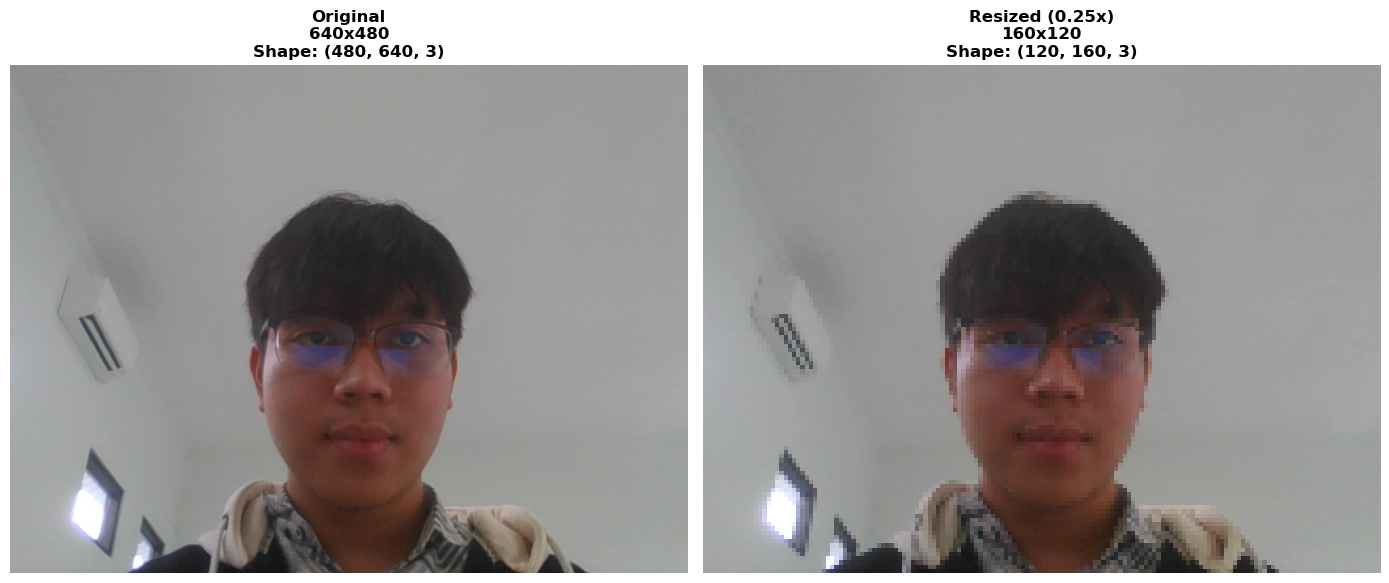

In [30]:
def demo_preprocessing_resize():
    """
    Demo: Proses resize gambar untuk optimasi performa
    Menunjukkan before/after resize dan pengaruhnya
    """
    print("=" * 70)
    print("DEMO 1: IMAGE RESIZE (OPTIMASI PERFORMA)")
    print("=" * 70)
    print("\n📷 Mengambil 1 frame dari kamera...\n")
    
    # Ambil 1 frame dari kamera
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia untuk demo")
        return
    
    # Skip beberapa frame untuk stabilisasi
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if not ret:
        print("❌ Gagal mengambil frame")
        return
    
    print("✓ Frame berhasil diambil!\n")
    
    # Original image
    original_height, original_width = frame.shape[:2]
    original_size = frame.nbytes / 1024  # KB
    
    # Resize untuk optimasi (0.25x seperti di absensi realtime)
    resize_factor = 0.25
    small_frame = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
    small_height, small_width = small_frame.shape[:2]
    small_size = small_frame.nbytes / 1024  # KB
    
    print("INFORMASI RESIZE:")
    print("-" * 70)
    print(f"Original Size    : {original_width}x{original_height} pixels ({original_size:.2f} KB)")
    print(f"Resized Size     : {small_width}x{small_height} pixels ({small_size:.2f} KB)")
    print(f"Resize Factor    : {resize_factor} ({resize_factor*100:.0f}%)")
    print(f"Size Reduction   : {(1 - small_size/original_size)*100:.1f}% lebih kecil")
    print(f"Pixel Reduction  : {(1 - (small_width*small_height)/(original_width*original_height))*100:.1f}% fewer pixels")
    print("-" * 70)
    print("\n💡 Kenapa resize?")
    print("   - Proses face detection lebih cepat (16x lebih sedikit pixel)")
    print("   - Memory usage lebih rendah")
    print("   - FPS lebih tinggi untuk realtime detection")
    print("   - Hasil deteksi tetap akurat karena wajah masih terlihat jelas\n")
    
    # Visualisasi
    visualize_before_after(
        frame, small_frame,
        title_before=f"Original\n{original_width}x{original_height}",
        title_after=f"Resized (0.25x)\n{small_width}x{small_height}",
        figsize=(14, 6)
    )
    
    return frame, small_frame

# Jalankan demo
frame_original, frame_resized = demo_preprocessing_resize()

### 2. BGR to RGB Conversion

DEMO 2: BGR to RGB CONVERSION

📷 Mengambil frame dari kamera...

✓ Kamera ditemukan di index 0
✓ Frame berhasil diambil!

INFORMASI KONVERSI:
----------------------------------------------------------------------
OpenCV Format    : BGR (Blue-Green-Red)
face_recognition : RGB (Red-Green-Blue)
Shape            : (480, 640, 3)
Data Type        : uint8
----------------------------------------------------------------------

💡 Kenapa perlu konversi?
   - OpenCV menggunakan BGR order (Blue, Green, Red)
   - face_recognition library butuh RGB order (Red, Green, Blue)
   - Tanpa konversi, warna akan tertukar (merah jadi biru)
   - Ini penting untuk konsistensi encoding!

CONTOH NILAI PIXEL (pixel pertama):
  BGR: B=123, G=140, R=137
  RGB: R=137, G=140, B=123



C:\Users\DELL\AppData\Local\Temp\ipykernel_6652\3949255373.py:34: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\miniconda3\envs\vis-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


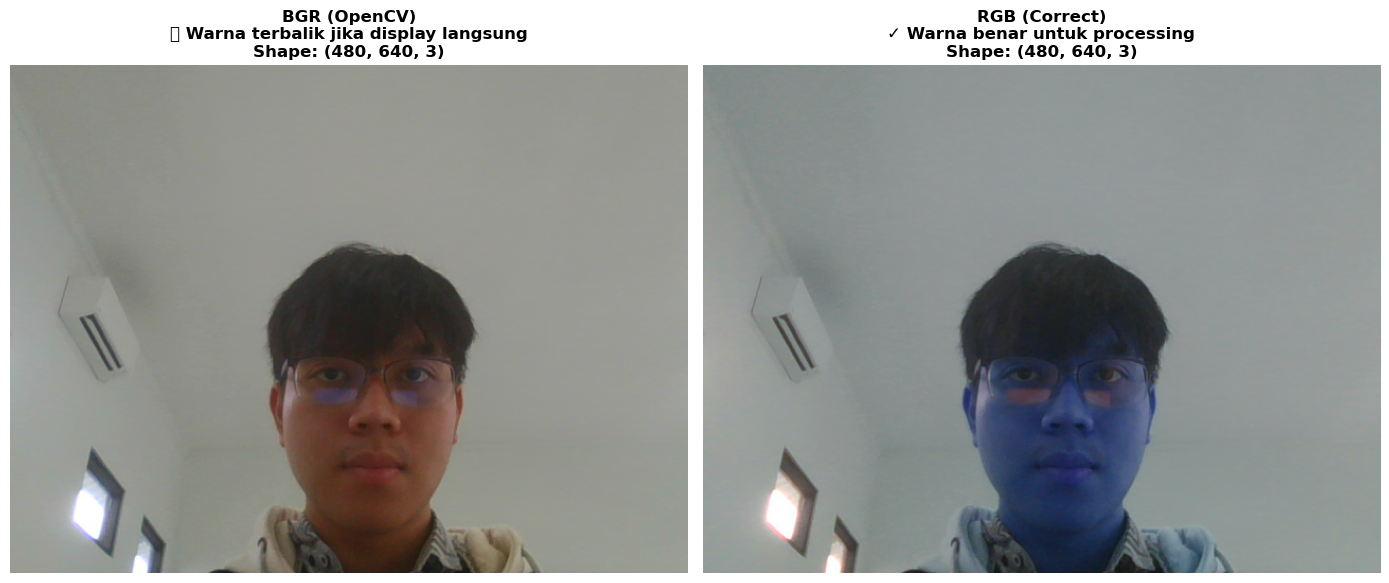

In [18]:
def demo_preprocessing_bgr_to_rgb():
    """
    Demo: Konversi BGR (OpenCV) ke RGB (face_recognition)
    Menunjukkan perbedaan color channel order
    """
    print("=" * 70)
    print("DEMO 2: BGR to RGB CONVERSION")
    print("=" * 70)
    print("\n📷 Mengambil frame dari kamera...\n")
    
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia")
        return
    
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if not ret:
        print("❌ Gagal mengambil frame")
        return
    
    print("✓ Frame berhasil diambil!\n")
    
    # BGR (OpenCV default)
    bgr_frame = frame.copy()
    
    # RGB (face_recognition requirement)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    print("INFORMASI KONVERSI:")
    print("-" * 70)
    print(f"OpenCV Format    : BGR (Blue-Green-Red)")
    print(f"face_recognition : RGB (Red-Green-Blue)")
    print(f"Shape            : {bgr_frame.shape}")
    print(f"Data Type        : {bgr_frame.dtype}")
    print("-" * 70)
    print("\n💡 Kenapa perlu konversi?")
    print("   - OpenCV menggunakan BGR order (Blue, Green, Red)")
    print("   - face_recognition library butuh RGB order (Red, Green, Blue)")
    print("   - Tanpa konversi, warna akan tertukar (merah jadi biru)")
    print("   - Ini penting untuk konsistensi encoding!\n")
    
    # Demonstrasi perbedaan channel
    print("CONTOH NILAI PIXEL (pixel pertama):")
    print(f"  BGR: B={bgr_frame[0,0,0]}, G={bgr_frame[0,0,1]}, R={bgr_frame[0,0,2]}")
    print(f"  RGB: R={rgb_frame[0,0,0]}, G={rgb_frame[0,0,1]}, B={rgb_frame[0,0,2]}")
    print()
    
    # Visualisasi - PENTING: untuk display yang benar
    # bgr_frame harus dikonversi dulu untuk ditampilkan dengan benar di matplotlib
    visualize_before_after(
        bgr_frame, rgb_frame,
        title_before="BGR (OpenCV)\n❌ Warna terbalik jika display langsung",
        title_after="RGB (Correct)\n✓ Warna benar untuk processing",
        figsize=(14, 6)
    )
    
    return bgr_frame, rgb_frame

# Jalankan demo
bgr_img, rgb_img = demo_preprocessing_bgr_to_rgb()

### 3. Face Detection Process

DEMO 3: FACE DETECTION PROCESS

📷 Mengambil frame dari kamera...

✓ Kamera ditemukan di index 0
✓ Frame berhasil diambil!
🔍 Mendeteksi wajah...

HASIL DETEKSI:
----------------------------------------------------------------------
Jumlah wajah     : 1
Waktu deteksi    : 20.47 ms
Model            : HOG (Histogram of Oriented Gradients)
----------------------------------------------------------------------

LOKASI WAJAH (koordinat pixel):
  Face 1: Top=240, Right=432, Bottom=412, Left=256
          Size: 176x172 pixels

💡 Cara kerja Face Detection:
   1. Resize gambar untuk performa (0.25x)
   2. Konversi BGR → RGB
   3. HOG algorithm mencari pola wajah
   4. Return koordinat kotak (top, right, bottom, left)
   5. Scale koordinat kembali ke ukuran asli (x4)



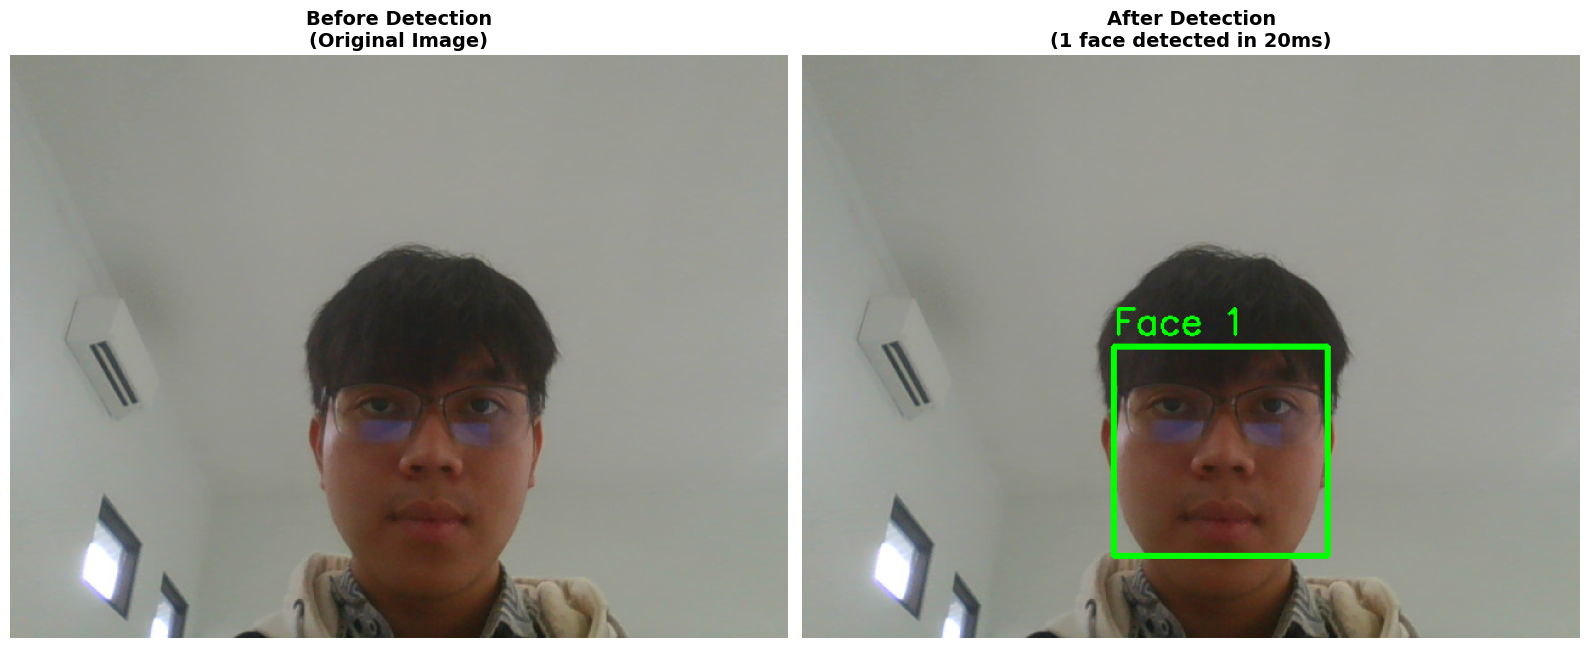

In [19]:
def demo_preprocessing_face_detection():
    """
    Demo: Proses face detection
    Menunjukkan bagaimana sistem menemukan lokasi wajah
    """
    print("=" * 70)
    print("DEMO 3: FACE DETECTION PROCESS")
    print("=" * 70)
    print("\n📷 Mengambil frame dari kamera...\n")
    
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia")
        return
    
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if not ret:
        print("❌ Gagal mengambil frame")
        return
    
    print("✓ Frame berhasil diambil!")
    print("🔍 Mendeteksi wajah...\n")
    
    # Resize untuk performa (seperti di sistem realtime)
    small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
    rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
    
    # Deteksi wajah dengan HOG model (cepat)
    import time
    start_time = time.time()
    face_locations_small = face_recognition.face_locations(rgb_small_frame, model='hog')
    detection_time = time.time() - start_time
    
    # Scale kembali lokasi wajah ke ukuran asli
    face_locations = []
    for (top, right, bottom, left) in face_locations_small:
        face_locations.append((top * 4, right * 4, bottom * 4, left * 4))
    
    print("HASIL DETEKSI:")
    print("-" * 70)
    print(f"Jumlah wajah     : {len(face_locations)}")
    print(f"Waktu deteksi    : {detection_time*1000:.2f} ms")
    print(f"Model            : HOG (Histogram of Oriented Gradients)")
    print("-" * 70)
    
    if len(face_locations) > 0:
        print("\nLOKASI WAJAH (koordinat pixel):")
        for i, (top, right, bottom, left) in enumerate(face_locations, 1):
            width = right - left
            height = bottom - top
            print(f"  Face {i}: Top={top}, Right={right}, Bottom={bottom}, Left={left}")
            print(f"          Size: {width}x{height} pixels")
        print()
    
    print("💡 Cara kerja Face Detection:")
    print("   1. Resize gambar untuk performa (0.25x)")
    print("   2. Konversi BGR → RGB")
    print("   3. HOG algorithm mencari pola wajah")
    print("   4. Return koordinat kotak (top, right, bottom, left)")
    print("   5. Scale koordinat kembali ke ukuran asli (x4)\n")
    
    # Visualisasi tanpa kotak
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Before detection
    axes[0].imshow(rgb_frame)
    axes[0].set_title("Before Detection\n(Original Image)", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # After detection dengan kotak
    result_img = rgb_frame.copy()
    for i, (top, right, bottom, left) in enumerate(face_locations, 1):
        cv2.rectangle(result_img, (left, top), (right, bottom), (0, 255, 0), 3)
        cv2.putText(result_img, f'Face {i}', (left, top - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    axes[1].imshow(result_img)
    axes[1].set_title(f"After Detection\n({len(face_locations)} face{'s' if len(face_locations) > 1 else ''} detected in {detection_time*1000:.0f}ms)", 
                     fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return frame, face_locations

# Jalankan demo
detected_frame, detected_faces = demo_preprocessing_face_detection()

### 4. Face Encoding Process (128D Vector)

DEMO 4: FACE ENCODING PROCESS (128D VECTOR)

📷 Mengambil frame dari kamera...

✓ Kamera ditemukan di index 0
✓ Frame berhasil diambil!
🔍 Mendeteksi wajah...
✓ 1 wajah terdeteksi!
🧮 Membuat encoding wajah...

✓ Encoding berhasil dibuat!

INFORMASI ENCODING:
----------------------------------------------------------------------
Format           : NumPy Array
Dimensi          : 128D (128 dimensi)
Data Type        : float64
Size in Memory   : 1024 bytes (1.00 KB)
Waktu encoding   : 500.83 ms
----------------------------------------------------------------------

Min value        : -0.337423
Max value        : 0.430710
Mean             : -0.003757
Std deviation    : 0.123272
Nilai positif    : 66/128 (51.6%)
Nilai negatif    : 62/128 (48.4%)
----------------------------------------------------------------------

💡 Apa itu Face Encoding?
   - Representasi matematis unik dari wajah seseorang
   - Berupa vektor 128 dimensi (128 angka)
   - Dibuat oleh deep neural network (dlib's ResNet)
   - S

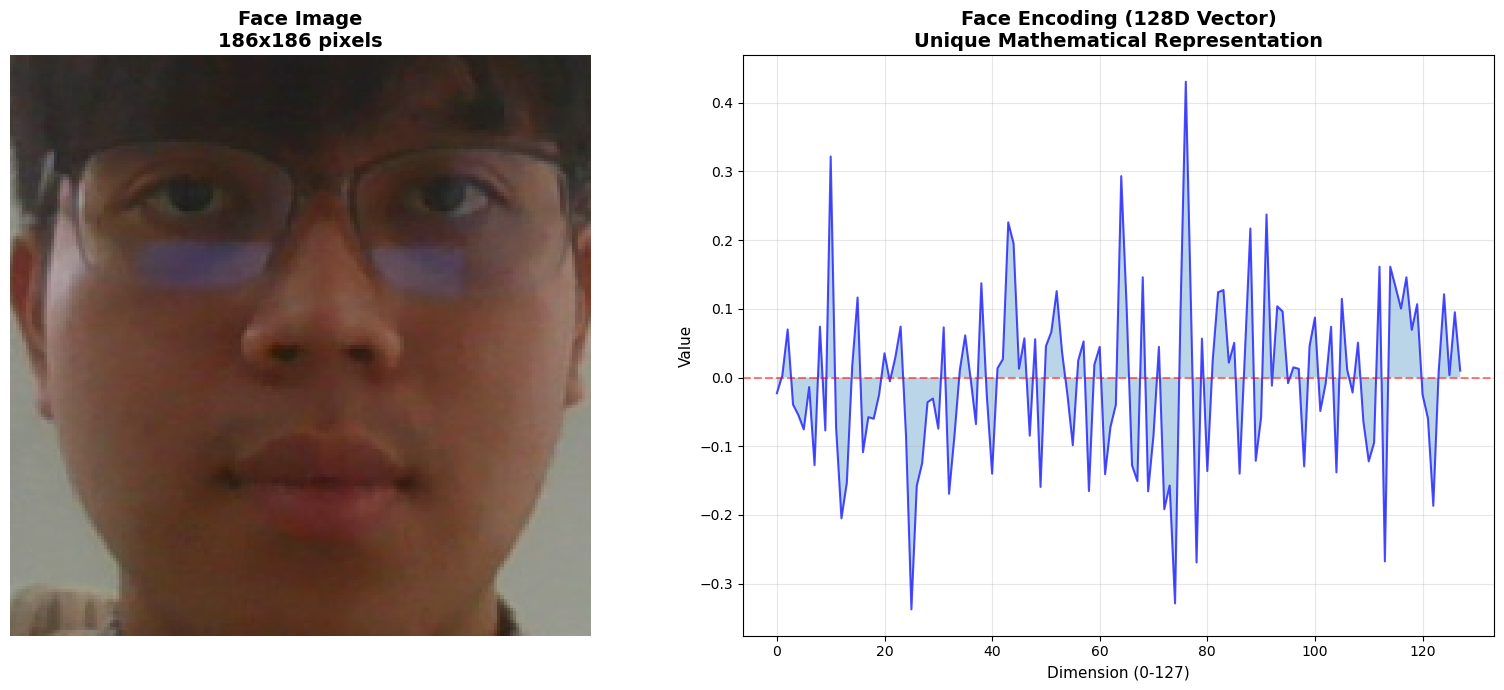


VISUALISASI ENCODING DETAIL:
----------------------------------------------------------------------


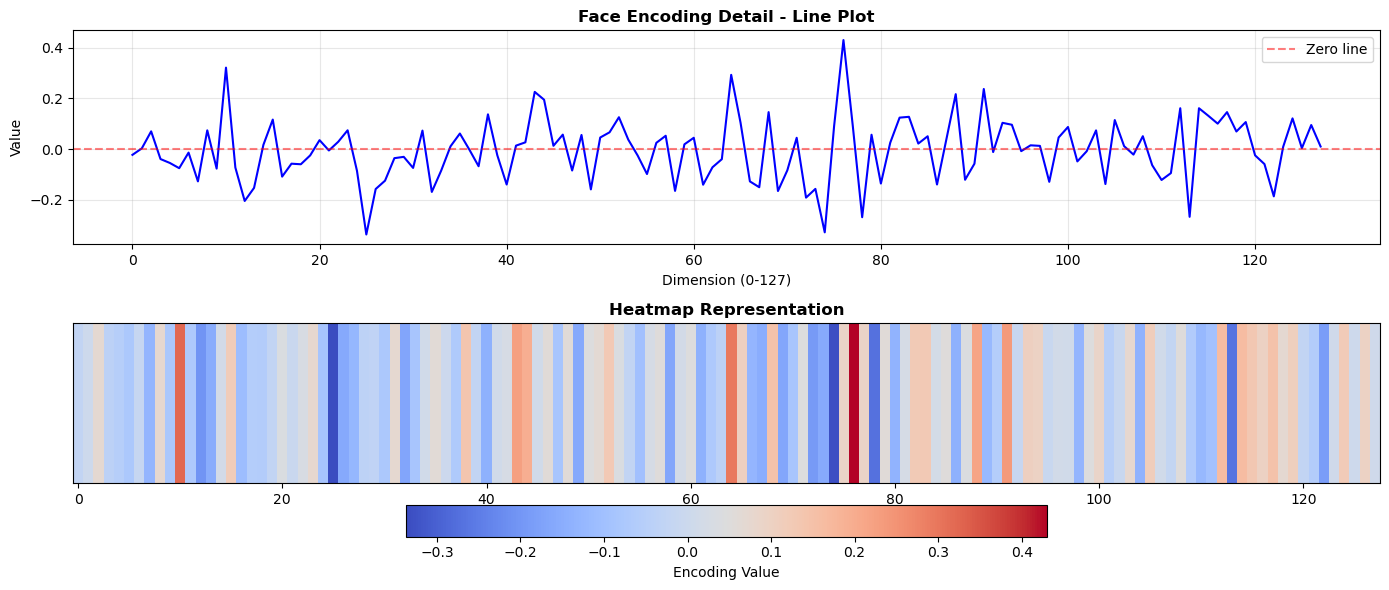

STATISTIK FACE ENCODING:
Dimensi        : 128D
Min value      : -0.3374
Max value      : 0.4307
Mean           : -0.0038
Std deviation  : 0.1233
Nilai positif  : 66 (51.6%)
Nilai negatif  : 62 (48.4%)


In [20]:
def demo_preprocessing_face_encoding():
    """
    Demo: Proses face encoding - mengubah wajah menjadi vektor 128D
    Ini adalah inti dari face recognition!
    """
    print("=" * 70)
    print("DEMO 4: FACE ENCODING PROCESS (128D VECTOR)")
    print("=" * 70)
    print("\n📷 Mengambil frame dari kamera...\n")
    
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia")
        return
    
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if not ret:
        print("❌ Gagal mengambil frame")
        return
    
    print("✓ Frame berhasil diambil!")
    print("🔍 Mendeteksi wajah...")
    
    # Preprocessing
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Deteksi wajah
    face_locations = face_recognition.face_locations(rgb_frame, model='hog')
    
    if len(face_locations) == 0:
        print("❌ Tidak ada wajah terdeteksi")
        print("   Silakan posisikan wajah di depan kamera dan jalankan ulang")
        return
    
    print(f"✓ {len(face_locations)} wajah terdeteksi!")
    print("🧮 Membuat encoding wajah...\n")
    
    # Encoding wajah
    import time
    start_time = time.time()
    face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
    encoding_time = time.time() - start_time
    
    if len(face_encodings) == 0:
        print("❌ Gagal membuat encoding")
        return
    
    # Ambil encoding pertama
    encoding = face_encodings[0]
    face_location = face_locations[0]
    
    print("✓ Encoding berhasil dibuat!\n")
    
    print("INFORMASI ENCODING:")
    print("-" * 70)
    print(f"Format           : NumPy Array")
    print(f"Dimensi          : {len(encoding)}D (128 dimensi)")
    print(f"Data Type        : {encoding.dtype}")
    print(f"Size in Memory   : {encoding.nbytes} bytes ({encoding.nbytes/1024:.2f} KB)")
    print(f"Waktu encoding   : {encoding_time*1000:.2f} ms")
    print("-" * 70)
    print(f"\nMin value        : {encoding.min():.6f}")
    print(f"Max value        : {encoding.max():.6f}")
    print(f"Mean             : {encoding.mean():.6f}")
    print(f"Std deviation    : {encoding.std():.6f}")
    print(f"Nilai positif    : {(encoding > 0).sum()}/{len(encoding)} ({(encoding > 0).sum()/len(encoding)*100:.1f}%)")
    print(f"Nilai negatif    : {(encoding < 0).sum()}/{len(encoding)} ({(encoding < 0).sum()/len(encoding)*100:.1f}%)")
    print("-" * 70)
    
    print("\n💡 Apa itu Face Encoding?")
    print("   - Representasi matematis unik dari wajah seseorang")
    print("   - Berupa vektor 128 dimensi (128 angka)")
    print("   - Dibuat oleh deep neural network (dlib's ResNet)")
    print("   - Setiap wajah punya encoding yang berbeda")
    print("   - Wajah yang sama akan punya encoding yang mirip")
    print("   - Digunakan untuk membandingkan & mengenali wajah\n")
    
    print("💡 Cara Kerja:")
    print("   1. Neural network menganalisis fitur wajah")
    print("   2. Fitur dikonversi jadi 128 angka floating-point")
    print("   3. Setiap dimensi merepresentasikan fitur tertentu")
    print("   4. Encoding disimpan untuk matching di masa depan\n")
    
    # Sample beberapa nilai encoding
    print("CONTOH 10 NILAI PERTAMA DARI ENCODING:")
    print(f"  {encoding[:10]}")
    print("\nCONTOH 10 NILAI TERAKHIR DARI ENCODING:")
    print(f"  {encoding[-10:]}\n")
    
    # Visualisasi wajah yang di-encode
    top, right, bottom, left = face_location
    face_img = rgb_frame[top:bottom, left:right]
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Gambar wajah
    axes[0].imshow(face_img)
    axes[0].set_title(f"Face Image\n{face_img.shape[1]}x{face_img.shape[0]} pixels", 
                     fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Encoding visualization (line plot)
    axes[1].plot(encoding, linewidth=1.5, color='blue', alpha=0.7)
    axes[1].fill_between(range(len(encoding)), encoding, alpha=0.3)
    axes[1].set_title("Face Encoding (128D Vector)\nUnique Mathematical Representation", 
                     fontsize=14, fontweight='bold')
    axes[1].set_xlabel("Dimension (0-127)", fontsize=11)
    axes[1].set_ylabel("Value", fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Visualisasi encoding sebagai heatmap
    print("\nVISUALISASI ENCODING DETAIL:")
    print("-" * 70)
    visualize_encoding_heatmap(encoding, title=f"Face Encoding Detail")
    
    return frame, encoding

# Jalankan demo
encoded_frame, my_encoding = demo_preprocessing_face_encoding()

### 5. Face Comparison (Face Distance)

In [ ]:
def demo_preprocessing_face_comparison():
    """
    Demo: Perbandingan 2 wajah menggunakan face distance
    Menunjukkan bagaimana sistem mengenali apakah 2 wajah adalah orang yang sama
    """
    print("=" * 70)
    print("DEMO 5: FACE COMPARISON (FACE DISTANCE)")
    print("=" * 70)
    print("\n📷 Ambil 2 foto wajah untuk dibandingkan\n")
    
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia")
        return
    
    encodings = []
    frames = []
    face_images = []
    
    for i in range(2):
        print(f"\n{'='*70}")
        print(f"FOTO {i+1}:")
        print(f"{'='*70}")
        
        if i == 0:
            print("Posisikan wajah Anda...")
            input("Tekan ENTER untuk ambil foto 1...")
        else:
            print("\n💡 Tips untuk foto 2:")
            print("   - Foto orang yang SAMA: Ubah sedikit posisi/ekspresi")
            print("   - Foto orang BERBEDA: Minta orang lain untuk difoto")
            input("Tekan ENTER untuk ambil foto 2...")
        
        # Skip frames untuk stabilisasi
        for _ in range(10):
            cap.read()
        
        ret, frame = cap.read()
        if not ret:
            print(f"❌ Gagal mengambil foto {i+1}")
            cap.release()
            return
        
        print(f"✓ Foto {i+1} berhasil diambil!")
        
        # Preprocessing
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Deteksi wajah
        face_locations = face_recognition.face_locations(rgb_frame, model='hog')
        
        if len(face_locations) == 0:
            print(f"❌ Tidak ada wajah di foto {i+1}")
            cap.release()
            return
        
        # Encoding
        face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
        
        if len(face_encodings) == 0:
            print(f"❌ Gagal encoding foto {i+1}")
            cap.release()
            return
        
        # Simpan
        encoding = face_encodings[0]
        face_location = face_locations[0]
        top, right, bottom, left = face_location
        face_img = rgb_frame[top:bottom, left:right]
        
        encodings.append(encoding)
        frames.append(rgb_frame)
        face_images.append(face_img)
        
        print(f"✓ Encoding foto {i+1} berhasil dibuat!")
        time.sleep(0.5)
    
    cap.release()
    cv2.destroyAllWindows()
    
    print(f"\n{'='*70}")
    print("MEMBANDINGKAN 2 WAJAH...")
    print(f"{'='*70}\n")
    
    # Hitung face distance
    distance = face_recognition.face_distance([encodings[0]], encodings[1])[0]
    
    # Hitung confidence
    confidence = (1 - distance) * 100
    
    # Tentukan match atau tidak (threshold 0.6)
    threshold = 0.6
    is_match = distance <= threshold
    
    print("HASIL PERBANDINGAN:")
    print("-" * 70)
    print(f"Face Distance    : {distance:.6f}")
    print(f"Confidence       : {confidence:.2f}%")
    print(f"Threshold        : {threshold}")
    print(f"Status           : {'MATCH ✓ (Orang yang sama)' if is_match else 'NOT MATCH ✗ (Orang berbeda)'}")
    print("-" * 70)
    
    print("\n💡 Cara Kerja Face Distance:")
    print("   1. Hitung Euclidean distance antara 2 encoding (128D)")
    print("   2. Distance kecil = wajah mirip (kemungkinan orang sama)")
    print("   3. Distance besar = wajah beda (kemungkinan orang berbeda)")
    print("   4. Threshold 0.6 = batas untuk menentukan match")
    print()
    print("   Interpretasi Distance:")
    print("   - 0.0 - 0.4  : Sangat yakin orang yang sama (excellent)")
    print("   - 0.4 - 0.5  : Yakin orang yang sama (good)")
    print("   - 0.5 - 0.6  : Mungkin orang yang sama (acceptable)")
    print("   - 0.6 - 0.7  : Meragukan (borderline)")
    print("   - > 0.7      : Kemungkinan besar orang berbeda")
    print()
    
    # Hitung statistik perbedaan encoding
    diff = np.abs(encodings[0] - encodings[1])
    
    print("STATISTIK PERBEDAAN ENCODING:")
    print("-" * 70)
    print(f"Mean difference      : {diff.mean():.6f}")
    print(f"Max difference       : {diff.max():.6f}")
    print(f"Min difference       : {diff.min():.6f}")
    print(f"Std difference       : {diff.std():.6f}")
    print(f"Dimensions > 0.5     : {(diff > 0.5).sum()}/{len(diff)} ({(diff > 0.5).sum()/len(diff)*100:.1f}%)")
    print("-" * 70)
    print()
    
    # Visualisasi perbandingan
    visualize_face_comparison(
        face_images[0], face_images[1],
        encodings[0], encodings[1],
        distance,
        title="Face Comparison Analysis"
    )
    
    return encodings, distance, is_match

# Jalankan demo
encodings_compared, compared_distance, match_result = demo_preprocessing_face_comparison()

### 6. Complete Preprocessing Pipeline (End-to-End)

In [ ]:
def demo_complete_preprocessing_pipeline():
    """
    Demo: Complete preprocessing pipeline dari kamera sampai face recognition
    Menunjukkan seluruh alur preprocessing dalam 1 flow
    """
    print("=" * 80)
    print("DEMO 6: COMPLETE PREPROCESSING PIPELINE (END-TO-END)")
    print("=" * 80)
    print("\nDemo ini menunjukkan SEMUA tahap preprocessing secara berurutan:")
    print("  1. Capture image dari kamera")
    print("  2. Resize untuk optimasi")
    print("  3. Konversi BGR → RGB")
    print("  4. Deteksi wajah (HOG)")
    print("  5. Face encoding (128D)")
    print("  6. Visualisasi setiap step\n")
    
    input("Tekan ENTER untuk mulai...")
    
    # STEP 1: Capture dari kamera
    print(f"\n{'='*80}")
    print("STEP 1: CAPTURE IMAGE")
    print(f"{'='*80}")
    
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak tersedia")
        return
    
    for _ in range(10):
        cap.read()
    
    ret, frame_original = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if not ret:
        print("❌ Gagal mengambil frame")
        return
    
    h_orig, w_orig = frame_original.shape[:2]
    print(f"✓ Frame captured: {w_orig}x{h_orig} pixels")
    print(f"  Format: BGR (OpenCV default)")
    print(f"  Size: {frame_original.nbytes/1024:.2f} KB")
    
    # STEP 2: Resize
    print(f"\n{'='*80}")
    print("STEP 2: RESIZE (0.25x untuk optimasi)")
    print(f"{'='*80}")
    
    resize_factor = 0.25
    frame_resized = cv2.resize(frame_original, (0, 0), fx=resize_factor, fy=resize_factor)
    h_small, w_small = frame_resized.shape[:2]
    
    print(f"✓ Resized: {w_orig}x{h_orig} → {w_small}x{h_small}")
    print(f"  Pixel reduction: {(1-(w_small*h_small)/(w_orig*h_orig))*100:.1f}%")
    print(f"  Size: {frame_resized.nbytes/1024:.2f} KB")
    print(f"  Purpose: Faster face detection")
    
    # STEP 3: BGR to RGB
    print(f"\n{'='*80}")
    print("STEP 3: COLOR CONVERSION (BGR → RGB)")
    print(f"{'='*80}")
    
    frame_rgb_small = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
    frame_rgb_original = cv2.cvtColor(frame_original, cv2.COLOR_BGR2RGB)
    
    print(f"✓ Converted to RGB")
    print(f"  Purpose: face_recognition library requires RGB format")
    print(f"  Channel order: Blue-Green-Red → Red-Green-Blue")
    
    # STEP 4: Face Detection
    print(f"\n{'='*80}")
    print("STEP 4: FACE DETECTION (HOG model)")
    print(f"{'='*80}")
    
    import time
    start_detect = time.time()
    face_locations_small = face_recognition.face_locations(frame_rgb_small, model='hog')
    detect_time = (time.time() - start_detect) * 1000
    
    # Scale kembali ke ukuran asli
    face_locations = []
    for (top, right, bottom, left) in face_locations_small:
        face_locations.append((top * 4, right * 4, bottom * 4, left * 4))
    
    print(f"✓ Detection complete: {len(face_locations)} face(s) found")
    print(f"  Time: {detect_time:.2f} ms")
    print(f"  Model: HOG (Histogram of Oriented Gradients)")
    
    if len(face_locations) == 0:
        print("\n❌ No face detected. Pipeline stopped.")
        print("   Please position your face in front of the camera and try again.")
        return
    
    # STEP 5: Face Encoding
    print(f"\n{'='*80}")
    print("STEP 5: FACE ENCODING (128D vector)")
    print(f"{'='*80}")
    
    start_encode = time.time()
    face_encodings = face_recognition.face_encodings(frame_rgb_original, face_locations)
    encode_time = (time.time() - start_encode) * 1000
    
    if len(face_encodings) == 0:
        print("\n❌ Failed to create encoding")
        return
    
    encoding = face_encodings[0]
    
    print(f"✓ Encoding created: 128D vector")
    print(f"  Time: {encode_time:.2f} ms")
    print(f"  Size: {encoding.nbytes} bytes")
    print(f"  Range: [{encoding.min():.4f}, {encoding.max():.4f}]")
    
    # STEP 6: Summary
    total_time = detect_time + encode_time
    print(f"\n{'='*80}")
    print("PIPELINE SUMMARY:")
    print(f"{'='*80}")
    print(f"Total processing time  : {total_time:.2f} ms")
    print(f"  - Face detection     : {detect_time:.2f} ms ({detect_time/total_time*100:.1f}%)")
    print(f"  - Face encoding      : {encode_time:.2f} ms ({encode_time/total_time*100:.1f}%)")
    print(f"Estimated FPS (max)    : {1000/total_time:.1f} fps")
    print(f"Face(s) processed      : {len(face_locations)}")
    print(f"Encoding dimension     : 128D")
    print(f"{'='*80}\n")
    
    # VISUALIZATION
    print("VISUALISASI SETIAP STEP:")
    print("-" * 80)
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, height_ratios=[2, 2, 1.5])
    
    # Row 1: Original, Resized, RGB
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(cv2.cvtColor(frame_original, cv2.COLOR_BGR2RGB))
    ax1.set_title(f"1. Original\n{w_orig}x{h_orig} | BGR", fontsize=11, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB))
    ax2.set_title(f"2. Resized (0.25x)\n{w_small}x{h_small} | {(1-(w_small*h_small)/(w_orig*h_orig))*100:.0f}% fewer pixels", 
                 fontsize=11, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(frame_rgb_small)
    ax3.set_title(f"3. BGR→RGB\nReady for processing", fontsize=11, fontweight='bold')
    ax3.axis('off')
    
    # Row 2: Face Detection Result
    ax4 = fig.add_subplot(gs[1, :])
    result_img = frame_rgb_original.copy()
    for i, (top, right, bottom, left) in enumerate(face_locations, 1):
        cv2.rectangle(result_img, (left, top), (right, bottom), (0, 255, 0), 4)
        cv2.putText(result_img, f'Face {i}', (left, top - 15),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    ax4.imshow(result_img)
    ax4.set_title(f"4. Face Detection Result\n{len(face_locations)} face(s) detected in {detect_time:.0f}ms", 
                 fontsize=13, fontweight='bold')
    ax4.axis('off')
    
    # Row 3: Encoding Visualization
    ax5 = fig.add_subplot(gs[2, :])
    ax5.plot(encoding, linewidth=2, color='darkblue', alpha=0.8)
    ax5.fill_between(range(len(encoding)), encoding, alpha=0.3, color='lightblue')
    ax5.set_title(f"5. Face Encoding (128D Vector)\nCreated in {encode_time:.0f}ms", 
                 fontsize=13, fontweight='bold')
    ax5.set_xlabel("Dimension (0-127)", fontsize=10)
    ax5.set_ylabel("Value", fontsize=10)
    ax5.grid(True, alpha=0.3)
    ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.suptitle("COMPLETE PREPROCESSING PIPELINE", fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Pipeline visualization complete!")
    print("\n💡 Key Takeaways:")
    print("   1. Resize menghemat ~94% memory dan mempercepat detection")
    print("   2. RGB conversion penting untuk konsistensi algoritma")
    print("   3. HOG detection sangat cepat (~50-100ms)")
    print("   4. Face encoding mengubah wajah jadi 128D vector unik")
    print("   5. Total pipeline < 200ms = bisa realtime (>5 FPS)")
    
    return frame_original, encoding

# Jalankan complete pipeline demo
result_frame, result_encoding = demo_complete_preprocessing_pipeline()

---

## A.3. RINGKASAN PREPROCESSING

Berikut adalah ringkasan lengkap alur preprocessing yang telah kita pelajari:

In [ ]:
# RINGKASAN PREPROCESSING FLOW

print("=" * 80)
print("RINGKASAN COMPLETE PREPROCESSING FLOW")
print("=" * 80)
print()

print("📊 TAHAP-TAHAP PREPROCESSING:")
print()

print("1️⃣  IMAGE CAPTURE")
print("   ├─ Input: Kamera (OpenCV VideoCapture)")
print("   ├─ Output: Frame BGR (contiguous numpy array)")
print("   ├─ Format: uint8, shape (height, width, 3)")
print("   └─ Purpose: Mendapatkan gambar untuk diproses")
print()

print("2️⃣  IMAGE RESIZE")
print("   ├─ Input: Frame BGR ukuran asli (contoh: 640x480)")
print("   ├─ Process: cv2.resize() dengan factor 0.25")
print("   ├─ Output: Frame BGR kecil (contoh: 160x120)")
print("   ├─ Benefit: ~94% lebih sedikit pixel = lebih cepat")
print("   └─ Purpose: Optimasi performa tanpa kurangi akurasi")
print()

print("3️⃣  COLOR CONVERSION")
print("   ├─ Input: Frame BGR (Blue-Green-Red)")
print("   ├─ Process: cv2.cvtColor(COLOR_BGR2RGB)")
print("   ├─ Output: Frame RGB (Red-Green-Blue)")
print("   ├─ Why: face_recognition library butuh RGB")
print("   └─ Purpose: Konsistensi format untuk encoding")
print()

print("4️⃣  FACE DETECTION")
print("   ├─ Input: Frame RGB (small)")
print("   ├─ Algorithm: HOG (Histogram of Oriented Gradients)")
print("   ├─ Process: face_recognition.face_locations()")
print("   ├─ Output: List of (top, right, bottom, left)")
print("   ├─ Time: ~50-100ms per frame")
print("   ├─ Scale back: Multiply coordinates by 4 (resize factor)")
print("   └─ Purpose: Temukan lokasi wajah di gambar")
print()

print("5️⃣  FACE ENCODING")
print("   ├─ Input: Frame RGB (full size) + face locations")
print("   ├─ Algorithm: Deep CNN (dlib's ResNet)")
print("   ├─ Process: face_recognition.face_encodings()")
print("   ├─ Output: 128D vector (numpy array float64)")
print("   ├─ Time: ~100-200ms per face")
print("   ├─ Size: 128 float64 = 1024 bytes per encoding")
print("   └─ Purpose: Representasi matematis unik wajah")
print()

print("6️⃣  FACE COMPARISON")
print("   ├─ Input: 2 face encodings (128D vectors)")
print("   ├─ Algorithm: Euclidean Distance")
print("   ├─ Process: face_recognition.face_distance()")
print("   ├─ Output: Distance (float, 0.0 = identik)")
print("   ├─ Threshold: 0.6 (0.0-0.6 = match, >0.6 = not match)")
print("   ├─ Confidence: (1 - distance) × 100%")
print("   └─ Purpose: Tentukan apakah 2 wajah adalah orang sama")
print()

print("7️⃣  STORAGE")
print("   ├─ Encoding → pickle.dumps() → bytes")
print("   ├─ Save to: Database (backend) atau File (notebook)")
print("   ├─ Format: .pickle file atau BLOB in SQLite")
print("   └─ Purpose: Simpan untuk matching di masa depan")
print()

print("=" * 80)
print("OPTIMASI YANG DITERAPKAN:")
print("=" * 80)
print()
print("✓ Resize 0.25x: Kurangi 94% pixel → 16x lebih cepat")
print("✓ HOG model: Lebih cepat dari CNN, akurasi cukup baik")
print("✓ Process every N frames: Skip frames untuk FPS lebih tinggi")
print("✓ Async I/O: Save file di background thread")
print("✓ NumPy vectorization: Operasi array sangat cepat")
print("✓ Tracking: Prevent re-detect wajah yang sama")
print()

print("=" * 80)
print("PERFORMANCE METRICS:")
print("=" * 80)
print()
print("Face Detection   : ~50-100 ms/frame")
print("Face Encoding    : ~100-200 ms/face")
print("Face Comparison  : ~0.1-1 ms (sangat cepat!)")
print("Total Pipeline   : ~150-300 ms")
print("Max FPS          : ~3-7 fps (cukup untuk realtime)")
print()

print("=" * 80)
print("KEY CONCEPTS:")
print("=" * 80)
print()
print("🔑 Face Encoding = Fingerprint digital wajah")
print("   - Setiap wajah punya encoding unik")
print("   - Wajah sama = encoding mirip (distance kecil)")
print("   - Wajah beda = encoding beda (distance besar)")
print()

print("🔑 Multiple Encodings per Person")
print("   - 1 encoding bisa error (posisi, cahaya, ekspresi)")
print("   - 3+ encoding = lebih robust dan akurat")
print("   - System compare dengan SEMUA encoding user")
print("   - Ambil yang terbaik (minimum distance)")
print()

print("🔑 Distance vs Confidence")
print("   - Distance: Jarak matematis antar encoding (0.0-1.0+)")
print("   - Confidence: User-friendly percentage (100%-0%)")
print("   - Formula: confidence = (1 - distance) × 100%")
print("   - Threshold 0.6 = balance antara false positive/negative")
print()

print("=" * 80)
print("PENGGUNAAN PRAKTIS:")
print("=" * 80)
print()
print("📝 REGISTRASI (Training):")
print("   1. Capture 3+ foto per orang")
print("   2. Buat encoding untuk tiap foto")
print("   3. Simpan semua encoding dengan ID user")
print("   → User siap untuk absensi!")
print()

print("✅ ABSENSI (Prediction):")
print("   1. Capture foto realtime dari kamera")
print("   2. Buat encoding dari foto")
print("   3. Compare dengan SEMUA encoding di database")
print("   4. Cari distance terkecil")
print("   5. Jika distance ≤ 0.6 → MATCH → Catat absensi")
print("   → Absensi tercatat otomatis!")
print()

print("=" * 80)
print()
print("✨ Selamat! Anda sudah memahami COMPLETE preprocessing flow!")
print("✨ Silakan jalankan demo-demo di atas untuk eksplorasi lebih lanjut!")
print()
print("=" * 80)

---

## B. MODUL REGISTRASI WAJAH

### Fungsi Registrasi Wajah Baru


In [4]:
def registrasi_wajah(nama, id_mahasiswa, jumlah_foto_minimal=3):
    """
    Registrasi wajah baru ke sistem dengan MULTIPLE ENCODINGS
    Minimum 3 foto diperlukan untuk akurasi optimal
    
    Parameters:
    - nama: Nama lengkap (string)
    - id_mahasiswa: NIM atau ID unik (string)
    - jumlah_foto_minimal: Jumlah foto minimal yang harus diambil (default: 3)
    
    Returns:
    - True jika berhasil, False jika gagal
    """
    
    print("=" * 60)
    print("REGISTRASI WAJAH (MULTIPLE ENCODINGS)")
    print("=" * 60)
    print(f"Nama: {nama}")
    print(f"ID: {id_mahasiswa}")
    print(f"Jumlah foto minimal: {jumlah_foto_minimal} foto")
    print("\n⚠ PENTING: Minimum 3 foto diperlukan untuk absensi!")
    print("\nInstruksi:")
    print("1. Pastikan wajah Anda terlihat jelas di kamera")
    print("2. Tekan 'c' untuk capture foto (minimal 3 kali)")
    print("3. Variasikan sedikit posisi/ekspresi untuk setiap foto")
    print("4. Tekan 'q' untuk keluar atau batalkan\n")
    
    # Cari kamera
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak dapat diakses")
        return False
    
    # List untuk menyimpan semua encoding dan foto
    all_encodings = []
    foto_count = 0
    
    # Reset error flag untuk memungkinkan error ditampilkan lagi
    if hasattr(registrasi_wajah, '_error_printed'):
        delattr(registrasi_wajah, '_error_printed')
    
    print("Membuka kamera...\n")
    time.sleep(1)
    
    # Skip beberapa frame awal untuk stabilisasi kamera
    for _ in range(5):
        cap.read()
    
    while foto_count < jumlah_foto_minimal:
        ret, frame = cap.read()
        if not ret:
            print("❌ Gagal membaca frame")
            break
        
        # Inisialisasi face_locations
        face_locations = []
        rgb_frame = None
        
        try:
            # Gunakan pendekatan yang SAMA PERSIS dengan absensi_realtime yang berfungsi
            # Resize frame untuk performa (0.25x seperti di absensi_realtime)
            small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
            
            # Konversi BGR ke RGB - SAMA PERSIS dengan absensi_realtime
            rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
            
            # Deteksi wajah - SAMA PERSIS dengan absensi_realtime (tanpa PIL, tanpa validasi tambahan)
            # Jika absensi_realtime berfungsi dengan cara ini, registrasi juga harusnya berfungsi
            face_locations_small = face_recognition.face_locations(rgb_small_frame)
            
            # Scale kembali lokasi wajah ke ukuran frame asli (kalikan dengan 4 karena resize 0.25x)
            face_locations = []
            for (top, right, bottom, left) in face_locations_small:
                face_locations.append((top * 4, right * 4, bottom * 4, left * 4))
            
            # Simpan rgb_frame untuk encoding nanti (gunakan frame asli untuk kualitas lebih baik)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Pastikan format yang benar untuk encoding
            if not rgb_frame.flags['C_CONTIGUOUS']:
                rgb_frame = np.ascontiguousarray(rgb_frame)
            if rgb_frame.dtype != np.uint8:
                rgb_frame = rgb_frame.astype(np.uint8)
                
        except cv2.error as e:
            # Error dari OpenCV
            face_locations = []
            rgb_frame = None
            if not hasattr(registrasi_wajah, '_error_printed'):
                print(f"⚠ Error OpenCV: {e}")
                print(f"   Frame shape: {frame.shape if frame is not None else 'None'}")
                print(f"   Frame dtype: {frame.dtype if frame is not None else 'None'}")
                registrasi_wajah._error_printed = True
        except (ValueError, AssertionError) as e:
            # Error validasi
            face_locations = []
            rgb_frame = None
            if not hasattr(registrasi_wajah, '_error_printed'):
                print(f"⚠ Error validasi: {e}")
                registrasi_wajah._error_printed = True
        except RuntimeError as e:
            # Error dari face_recognition
            face_locations = []
            rgb_frame = None
            if not hasattr(registrasi_wajah, '_error_printed'):
                print(f"⚠ Error Runtime dari face_recognition: {e}")
                print(f"   Frame shape: {frame.shape if 'frame' in locals() else 'N/A'}")
                print(f"   Frame dtype: {frame.dtype if 'frame' in locals() else 'N/A'}")
                print(f"   NumPy version: {np.__version__}")
                if hasattr(np, '__version__') and int(np.__version__.split('.')[0]) >= 2:
                    print("   ⚠ NumPy 2.x mungkin tidak kompatibel!")
                    print("   Coba downgrade: pip install numpy==1.23.5")
                registrasi_wajah._error_printed = True
        except Exception as e:
            # Error lainnya
            face_locations = []
            rgb_frame = None
            # Hanya print error sekali untuk menghindari spam
            if not hasattr(registrasi_wajah, '_error_printed'):
                print(f"⚠ Error dalam deteksi wajah: {e}")
                print(f"   Error type: {type(e).__name__}")
                registrasi_wajah._error_printed = True
        
        # Gambar kotak di sekitar wajah
        display_frame = frame.copy()
        for (top, right, bottom, left) in face_locations:
            cv2.rectangle(display_frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.putText(display_frame, "Wajah Terdeteksi", (left, top - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Status dengan progress
        if len(face_locations) > 0:
            status_text = f"STATUS: Wajah terdeteksi - Tekan 'c' untuk capture ({foto_count + 1}/{jumlah_foto_minimal})"
            color = (0, 255, 0)
        else:
            status_text = f"STATUS: Posisikan wajah di depan kamera ({foto_count + 1}/{jumlah_foto_minimal})"
            color = (0, 0, 255)
        
        # Tips untuk variasi foto
        if foto_count == 0:
            tip = "Foto 1: Wajah lurus, ekspresi netral"
        elif foto_count == 1:
            tip = "Foto 2: Sedikit miring kiri/kanan"
        elif foto_count == 2:
            tip = "Foto 3: Sedikit miring kanan/kiri atau ekspresi berbeda"
        else:
            tip = f"Foto {foto_count + 1}: Variasi posisi/ekspresi"
        
        cv2.putText(display_frame, status_text, (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        cv2.putText(display_frame, f"Nama: {nama} | ID: {id_mahasiswa}", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(display_frame, tip, (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
        cv2.putText(display_frame, "'c' = capture | 'q' = keluar", (10, display_frame.shape[0] - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        
        cv2.imshow('Registrasi Wajah', display_frame)
        
        key = cv2.waitKey(1) & 0xFF
        
        # Capture foto
        if key == ord('c'):
            if len(face_locations) > 0:
                # Simpan foto dengan nomor urut
                filename = f"{nama}_{id_mahasiswa}_{foto_count + 1}.jpg"
                filepath = os.path.join('dataset_wajah', filename)
                cv2.imwrite(filepath, frame)
                print(f"\n✓ Foto {foto_count + 1} berhasil disimpan: {filepath}")
                
                # Encode wajah
                print("Membuat encoding wajah...")
                if rgb_frame is None:
                    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    if not rgb_frame.flags['C_CONTIGUOUS']:
                        rgb_frame = np.ascontiguousarray(rgb_frame)
                    if rgb_frame.dtype != np.uint8:
                        rgb_frame = rgb_frame.astype(np.uint8)
                
                try:
                    face_encoding = face_recognition.face_encodings(rgb_frame, face_locations)[0]
                    all_encodings.append(face_encoding)
                    foto_count += 1
                    print(f"✓ Encoding {foto_count} berhasil dibuat")
                    
                    if foto_count < jumlah_foto_minimal:
                        print(f"  Ambil {jumlah_foto_minimal - foto_count} foto lagi...")
                        print("  (Variasi sedikit posisi/ekspresi untuk hasil lebih baik)\n")
                        time.sleep(1.5)  # Pause sebelum foto berikutnya
                    else:
                        print("\n✓ Semua foto minimal berhasil diambil!")
                        break
                except Exception as e:
                    print(f"❌ Error saat encoding: {e}")
            else:
                print("\n⚠ Tidak ada wajah yang terdeteksi. Posisikan wajah dengan benar.")
        
        # Keluar
        elif key == ord('q'):
            if foto_count > 0:
                print(f"\n⚠ Anda sudah mengambil {foto_count} foto dari {jumlah_foto_minimal} yang diperlukan.")
                print("⚠ Registrasi tidak akan tersimpan jika kurang dari minimum!")
                konfirmasi = input("Yakin ingin keluar? (y/n): ")
                if konfirmasi.lower() != 'y':
                    continue
            print("\nRegistrasi dibatalkan.")
            break
    
    # Tutup kamera
    cap.release()
    cv2.destroyAllWindows()
    for i in range(4):
        cv2.waitKey(1)
    
    # Simpan semua encoding jika memenuhi minimum
    if len(all_encodings) >= jumlah_foto_minimal:
        encoding_data = {
            'nama': nama,
            'id': id_mahasiswa,
            'encodings': all_encodings,  # ARRAY of encodings
            'jumlah_encoding': len(all_encodings),
            'tanggal_registrasi': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'format': 'multiple'
        }
        
        encoding_filename = f"{nama}_{id_mahasiswa}.pickle"
        encoding_filepath = os.path.join('encodings', encoding_filename)
        
        with open(encoding_filepath, 'wb') as f:
            pickle.dump(encoding_data, f)
        
        print(f"\n✓ {len(all_encodings)} encoding berhasil disimpan: {encoding_filepath}")
        print("=" * 60)
        print("✓ REGISTRASI BERHASIL!")
        print("=" * 60)
        print(f"✓ {len(all_encodings)} foto dan encoding tersimpan")
        print("✓ Anda sekarang dapat melakukan absensi!")
        print("=" * 60)
        return True
    else:
        print("\n" + "=" * 60)
        print("❌ REGISTRASI GAGAL!")
        print("=" * 60)
        print(f"⚠ Hanya {len(all_encodings)} foto yang berhasil diambil")
        print(f"⚠ Minimum {jumlah_foto_minimal} foto diperlukan untuk absensi")
        print("⚠ Data tidak disimpan. Silakan registrasi ulang dengan minimal 3 foto.")
        print("=" * 60)
        return False

print("✓ Fungsi registrasi_wajah (MULTIPLE ENCODINGS) siap digunakan!")


✓ Fungsi registrasi_wajah (MULTIPLE ENCODINGS) siap digunakan!


### Proses Registrasi Wajah dan Identitas

**Jalankan cell di bawah untuk mendaftarkan wajah baru:**


In [5]:
# CONTOH REGISTRASI - Edit nama dan ID sesuai kebutuhan

nama_mahasiswa = input("Masukkan Nama: ")
nim_mahasiswa = input("Masukkan NIM/ID: ")

# Validasi input
if nama_mahasiswa.strip() == "" or nim_mahasiswa.strip() == "":
    print("❌ Nama dan ID tidak boleh kosong!")
else:
    hasil = registrasi_wajah(nama_mahasiswa, nim_mahasiswa)
    if hasil:
        print("\n✓ Registrasi selesai! Wajah berhasil didaftarkan ke sistem.")
    else:
        print("\n❌ Registrasi gagal. Silakan coba lagi.")


Masukkan Nama:  Ren
Masukkan NIM/ID:  23215030


REGISTRASI WAJAH (MULTIPLE ENCODINGS)
Nama: Ren
ID: 23215030
Jumlah foto minimal: 3 foto

⚠ PENTING: Minimum 3 foto diperlukan untuk absensi!

Instruksi:
1. Pastikan wajah Anda terlihat jelas di kamera
2. Tekan 'c' untuk capture foto (minimal 3 kali)
3. Variasikan sedikit posisi/ekspresi untuk setiap foto
4. Tekan 'q' untuk keluar atau batalkan

✓ Kamera ditemukan di index 0
Membuka kamera...


✓ Foto 1 berhasil disimpan: dataset_wajah\Ren_23215030_1.jpg
Membuat encoding wajah...
✓ Encoding 1 berhasil dibuat
  Ambil 2 foto lagi...
  (Variasi sedikit posisi/ekspresi untuk hasil lebih baik)


✓ Foto 2 berhasil disimpan: dataset_wajah\Ren_23215030_2.jpg
Membuat encoding wajah...
✓ Encoding 2 berhasil dibuat
  Ambil 1 foto lagi...
  (Variasi sedikit posisi/ekspresi untuk hasil lebih baik)


✓ Foto 3 berhasil disimpan: dataset_wajah\Ren_23215030_3.jpg
Membuat encoding wajah...
✓ Encoding 3 berhasil dibuat

✓ Semua foto minimal berhasil diambil!

✓ 3 encoding berhasil disimpan: encodings\Ren

---

## C. MODUL ABSENSI WAJAH (REALTIME)

### Load Semua Encoding Wajah yang Terdaftar


In [6]:
def load_encodings(min_encoding_per_orang=3):
    """
    Load semua encoding wajah dari folder encodings/
    Support untuk format lama (single encoding) dan format baru (multiple encodings)
    Validasi minimum encoding per orang untuk absensi
    
    Parameters:
    - min_encoding_per_orang: Minimum encoding per orang untuk valid (default: 3)
    
    Returns:
    - known_encodings: list of face encodings (bisa multiple per orang)
    - known_data: list of dictionaries {'nama': ..., 'id': ...}
    """
    known_encodings = []
    known_data = []
    
    encoding_files = [f for f in os.listdir('encodings') if f.endswith('.pickle')]
    
    if len(encoding_files) == 0:
        print("⚠ Tidak ada encoding yang ditemukan!")
        print("Silakan registrasi wajah terlebih dahulu.")
        return [], []
    
    print(f"Loading {len(encoding_files)} file encoding...")
    
    total_encodings = 0
    valid_count = 0
    invalid_count = 0
    
    for filename in encoding_files:
        filepath = os.path.join('encodings', filename)
        try:
            with open(filepath, 'rb') as f:
                data = pickle.load(f)
                
                # Format baru: multiple encodings
                if 'encodings' in data and isinstance(data['encodings'], list):
                    encodings = data['encodings']
                    jumlah = len(encodings)
                    
                    # Validasi minimum encoding
                    if jumlah >= min_encoding_per_orang:
                        known_encodings.extend(encodings)
                        for i in range(jumlah):
                            known_data.append({
                                'nama': data['nama'],
                                'id': data['id'],
                                'encoding_index': i + 1,
                                'total_encodings': jumlah
                            })
                        total_encodings += jumlah
                        valid_count += 1
                        print(f"  ✓ {data['nama']} ({data['id']}) - {jumlah} encoding [VALID]")
                    else:
                        invalid_count += 1
                        print(f"  ⚠ {data['nama']} ({data['id']}) - {jumlah} encoding [TIDAK VALID - < {min_encoding_per_orang}]")
                
                # Format lama: single encoding (backward compatible, tapi tidak valid untuk absensi)
                elif 'encoding' in data:
                    invalid_count += 1
                    print(f"  ⚠ {data['nama']} ({data['id']}) - 1 encoding [FORMAT LAMA - Perlu registrasi ulang]")
                
                else:
                    invalid_count += 1
                    print(f"  ❌ {filename}: Format tidak dikenali")
                    
        except Exception as e:
            invalid_count += 1
            print(f"  ❌ Error loading {filename}: {e}")
    
    print(f"\n✓ Total {total_encodings} encoding dari {valid_count} orang VALID berhasil di-load!")
    if invalid_count > 0:
        print(f"⚠ {invalid_count} orang tidak valid (perlu registrasi ulang dengan minimal {min_encoding_per_orang} foto)")
    
    if len(known_encodings) == 0:
        print("\n❌ Tidak ada encoding yang valid untuk absensi!")
        print(f"   Silakan registrasi wajah dengan minimal {min_encoding_per_orang} foto per orang.")
    
    return known_encodings, known_data

print("✓ Fungsi load_encodings (MULTIPLE ENCODINGS + VALIDASI) siap digunakan!")


✓ Fungsi load_encodings (MULTIPLE ENCODINGS + VALIDASI) siap digunakan!


In [7]:
def absensi_realtime():
    """
    Jalankan sistem absensi realtime dengan deteksi wajah (OPTIMASI MULTIPLE ENCODINGS)
    - Bingkai tidak kedip-kedip (tracking posisi)
    - Foto hanya disimpan sekali saat pertama kali terdeteksi
    - Optimasi performa untuk multiple encodings
    - Smooth dan tidak lag
    """
    import threading
    from queue import Queue
    
    print("=" * 60)
    print("SISTEM ABSENSI REALTIME (OPTIMASI MULTIPLE ENCODINGS)")
    print("=" * 60)
    
    # Load encoding dengan validasi minimum
    known_encodings, known_data = load_encodings(min_encoding_per_orang=3)
    
    if len(known_encodings) == 0:
        print("\n❌ Tidak ada encoding yang valid untuk absensi!")
        print("   Silakan registrasi wajah dengan minimal 3 foto per orang.")
        return
    
    # ========== OPTIMASI: Pre-compute array NumPy sekali ==========
    known_encodings_array = np.array(known_encodings)
    
    # ========== OPTIMASI: Group encodings per orang untuk tracking ==========
    # Buat mapping: person_id -> list of encoding indices
    person_encoding_map = {}
    for idx, person_data in enumerate(known_data):
        person_id = person_data['id']
        if person_id not in person_encoding_map:
            person_encoding_map[person_id] = []
        person_encoding_map[person_id].append(idx)
    
    total_orang = len(person_encoding_map)
    total_encodings = len(known_encodings)
    avg_encoding = total_encodings / total_orang if total_orang > 0 else 0
    
    print(f"Total encoding: {total_encodings} dari {total_orang} orang")
    print(f"Rata-rata: {avg_encoding:.1f} encoding/orang")
    
    # Cari kamera
    camera_index, cap = find_camera()
    if cap is None:
        print("❌ Kamera tidak dapat diakses")
        return
    
    # Set untuk tracking siapa yang sudah absen di sesi ini
    sudah_absen = set()
    
    # ========== FIX: Tracking untuk bingkai tidak kedip-kedip ==========
    # Simpan posisi dan info wajah terakhir yang terdeteksi
    last_detected_faces = []  # List of {'person_id': ..., 'box': (top, right, bottom, left), 'nama': ..., 'confidence': ...}
    # ===================================================================
    
    # Queue untuk batch I/O operations (threading)
    save_queue = Queue()
    
    def save_worker():
        """Thread worker untuk menyimpan data secara asynchronous"""
        df_absensi = pd.read_csv('absensi.csv')
        while True:
            item = save_queue.get()
            if item is None:  # Signal untuk stop
                if len(df_absensi) > 0:
                    df_absensi.to_csv('absensi.csv', index=False)
                break
            
            new_row = pd.DataFrame([{
                'nama': item['nama'],
                'id': item['id'],
                'waktu': item['waktu']
            }])
            df_absensi = pd.concat([df_absensi, new_row], ignore_index=True)
            
            # ========== FIX: Hanya simpan foto sekali ==========
            cv2.imwrite(item["output_path"], item["frame"])
            # ===================================================
            
            if save_queue.qsize() == 0 or len(df_absensi) % 3 == 0:
                df_absensi.to_csv('absensi.csv', index=False)
            
            save_queue.task_done()
    
    io_thread = threading.Thread(target=save_worker, daemon=True)
    io_thread.start()
    
    print("\nInstruksi:")
    print("- Posisikan wajah di depan kamera")
    print("- Sistem akan otomatis mendeteksi dan mencatat absensi")
    print("- Maksimal 2 wajah diproses sekaligus untuk performa optimal")
    print("- Tekan 'q' untuk keluar\n")
    print("Membuka kamera...\n")
    time.sleep(2)
    
    # ========== PARAMETER OPTIMASI DINAMIS ==========
    frame_count = 0
    
    # Optimasi dinamis berdasarkan jumlah encoding
    if total_encodings <= 20:
        # Sedikit encoding: bisa lebih agresif
        process_every_n_frames = 3  # Process lebih sering
        resize_factor = 0.25  # Resolusi lebih tinggi
    elif total_encodings <= 100:
        # Sedang: setting default
        process_every_n_frames = 4  # Default
        resize_factor = 0.2  # Default
    else:
        # Banyak encoding: lebih agresif skip
        process_every_n_frames = 5  # Skip lebih banyak
        resize_factor = 0.15  # Resolusi lebih rendah
    
    use_hog_model = True  # Gunakan HOG model (lebih cepat)
    max_faces = 2  # Limit maksimal 2 wajah
    frame_timeout = 10  # FIX: Hapus bingkai setelah 10 frame tidak terdeteksi
    
    print(f"⚙️  Optimasi: Process setiap {process_every_n_frames} frame, Resize {resize_factor*100:.0f}%")
    print(f"⚙️  Total encoding: {total_encodings}\n")
    # ========================================
    
    frame_without_detection = 0  # Counter untuk menghapus bingkai lama
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("❌ Gagal membaca frame")
            break
        
        frame_count += 1
        
        # ========== FIX: Gambar bingkai dari tracking di SEMUA frame ==========
        # Ini membuat bingkai tidak kedip-kedip
        current_detected_faces = []
        scale_factor = int(1 / resize_factor)
        
        # Gambar bingkai dari deteksi terakhir
        for face_info in last_detected_faces:
            top, right, bottom, left = face_info['box']
            nama = face_info['nama']
            person_id = face_info['person_id']
            confidence = face_info.get('confidence', 0)
            
            # Gambar kotak dan nama (selalu muncul di semua frame)
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 2)
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 255, 0), cv2.FILLED)
            cv2.putText(frame, f"{nama} ({person_id})", (left + 6, bottom - 6),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        # ======================================================================
        
        # Process hanya setiap n frame (skip lebih banyak untuk performa)
        if frame_count % process_every_n_frames == 0:
            # Resize untuk performa
            small_frame = cv2.resize(frame, (0, 0), fx=resize_factor, fy=resize_factor)
            rgb_small_frame = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
            
            # Deteksi wajah dengan HOG model (lebih cepat)
            if use_hog_model:
                face_locations = face_recognition.face_locations(rgb_small_frame, model='hog')
            else:
                face_locations = face_recognition.face_locations(rgb_small_frame)
            
            # OPTIMASI: Limit maksimal wajah yang diproses
            if len(face_locations) > max_faces:
                face_areas = [(bottom - top) * (right - left)
                              for (top, right, bottom, left) in face_locations]
                sorted_indices = sorted(range(len(face_areas)),
                                       key=lambda i: face_areas[i], reverse=True)
                face_locations = [face_locations[i] for i in sorted_indices[:max_faces]]
            
            # Encoding wajah yang terdeteksi
            if len(face_locations) > 0:
                face_encodings = face_recognition.face_encodings(rgb_small_frame, face_locations)
                frame_without_detection = 0  # Reset counter
                
                # Loop untuk setiap wajah yang terdeteksi
                for face_encoding, face_location in zip(face_encodings, face_locations):
                    # ========== OPTIMASI: compare_faces sudah dioptimasi NumPy ==========
                    # Operasi ini sangat cepat meskipun dengan banyak encoding
                    matches = face_recognition.compare_faces(
                        known_encodings_array, 
                        face_encoding, 
                        tolerance=0.6
                    )
                    face_distances = face_recognition.face_distance(
                        known_encodings_array, 
                        face_encoding
                    )
                    best_match_index = np.argmin(face_distances)
                    
                    if matches[best_match_index]:
                        person_data = known_data[best_match_index]
                        nama = person_data['nama']
                        person_id = person_data['id']
                        confidence = (1 - face_distances[best_match_index]) * 100
                        
                        # ========== OPTIMASI: Cari encoding terbaik dari orang yang sama ==========
                        # Jika orang ini punya multiple encodings, cari yang terbaik
                        if person_id in person_encoding_map and len(person_encoding_map[person_id]) > 1:
                            # Cari encoding dengan confidence tertinggi dari orang yang sama
                            person_indices = person_encoding_map[person_id]
                            person_distances = [face_distances[i] for i in person_indices]
                            best_person_index = person_indices[np.argmin(person_distances)]
                            best_person_distance = min(person_distances)
                            confidence = (1 - best_person_distance) * 100
                            
                            # Update person_data dengan yang terbaik
                            person_data = known_data[best_person_index]
                            nama = person_data['nama']
                            person_id = person_data['id']
                        
                        # Scale kembali lokasi wajah
                        top, right, bottom, left = face_location
                        top *= scale_factor
                        right *= scale_factor
                        bottom *= scale_factor
                        left *= scale_factor
                        
                        # ========== FIX: Update tracking dengan posisi baru ==========
                        # Simpan info wajah untuk ditampilkan di frame berikutnya
                        current_detected_faces.append({
                            'person_id': person_id,
                            'box': (top, right, bottom, left),
                            'nama': nama,
                            'confidence': confidence
                        })
                        # ============================================================
                        
                        # ========== FIX: Catat absensi HANYA jika belum absen ==========
                        if person_id not in sudah_absen:
                            waktu_sekarang = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                            output_filename = f"{nama}_{person_id}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.jpg"
                            output_path = os.path.join('output', output_filename)
                            
                            # OPTIMASI: Async I/O dengan queue (non-blocking)
                            # HANYA simpan sekali saat pertama kali terdeteksi
                            save_queue.put({
                                'nama': nama,
                                'id': person_id,
                                'waktu': waktu_sekarang,
                                'frame': frame.copy(),  # Copy frame untuk thread
                                'output_path': output_path
                            })
                            
                            # Tandai sudah absen (PENTING: ini mencegah save berulang)
                            sudah_absen.add(person_id)
                            
                            print(f"\n{'='*60}")
                            print(f"✓ ABSENSI TERCATAT")
                            print(f"{'='*60}")
                            print(f"Nama       : {nama}")
                            print(f"ID         : {person_id}")
                            print(f"Waktu      : {waktu_sekarang}")
                            print(f"Confidence : {confidence:.2f}%")
                            print(f"Foto       : {output_path}")
                            print(f"{'='*60}\n")
                    else:
                        # Wajah tidak dikenali - tidak perlu tracking
                        top, right, bottom, left = face_location
                        top *= scale_factor
                        right *= scale_factor
                        bottom *= scale_factor
                        left *= scale_factor
                        
                        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
                        cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                        cv2.putText(frame, "Tidak Dikenali", (left + 6, bottom - 6),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                # ========== FIX: Update tracking dengan wajah yang baru terdeteksi ==========
                last_detected_faces = current_detected_faces
                # ===========================================================================
            else:
                # Tidak ada wajah terdeteksi
                frame_without_detection += 1
                # Hapus bingkai lama setelah beberapa frame tidak terdeteksi
                if frame_without_detection > frame_timeout:
                    last_detected_faces = []
        
        # Tambahkan info ke frame
        estimated_fps = 30 // process_every_n_frames
        cv2.putText(frame, "SISTEM ABSENSI - Tekan 'q' untuk keluar", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(frame, f"Sudah Absen: {len(sudah_absen)} orang", (10, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
        cv2.putText(frame, f"FPS: ~{estimated_fps} | Encoding: {total_encodings} | Max: {max_faces} wajah", (10, 90),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
        
        cv2.imshow('Absensi Realtime', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Stop worker thread
    save_queue.put(None)
    io_thread.join(timeout=2)  # Tunggu max 2 detik untuk selesai
    
    # Tutup kamera
    cap.release()
    cv2.destroyAllWindows()
    for i in range(4):
        cv2.waitKey(1)
    
    print("\n" + "=" * 60)
    print("SESI ABSENSI SELESAI")
    print("=" * 60)
    print(f"Total yang hadir: {len(sudah_absen)} orang")
    if len(sudah_absen) > 0:
        print("\nDaftar yang hadir:")
        for person_id in sudah_absen:
            for data in known_data:
                if data['id'] == person_id:
                    print(f"  - {data['nama']} ({person_id})")
    print("=" * 60)

print("✓ Fungsi absensi_realtime (OPTIMASI MULTIPLE ENCODINGS) siap digunakan!")

✓ Fungsi absensi_realtime (OPTIMASI MULTIPLE ENCODINGS) siap digunakan!


---

## A.2. DEMO PREPROCESSING: IMAGE RESIZE

**Visualisasi Before & After Resize**

In [ ]:
# DEMO 1: IMAGE RESIZE (Before vs After)
print("=" * 70)
print("DEMO 1: IMAGE RESIZE - OPTIMASI PERFORMA")
print("=" * 70)
print("\n📷 Mengambil frame dari kamera...\n")

# Ambil frame dari kamera
camera_idx, cap = find_camera()
if cap is not None:
    for _ in range(10):  # Skip frames
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if ret:
        print("✓ Frame berhasil diambil!\n")
        
        # Original
        h_orig, w_orig = frame.shape[:2]
        size_orig = frame.nbytes / 1024
        
        # Resize 0.25x
        frame_small = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        h_small, w_small = frame_small.shape[:2]
        size_small = frame_small.nbytes / 1024
        
        print(f"Original    : {w_orig}x{h_orig} pixels ({size_orig:.2f} KB)")
        print(f"Resized     : {w_small}x{h_small} pixels ({size_small:.2f} KB)")
        print(f"Reduction   : {(1-size_small/size_orig)*100:.1f}% lebih kecil\n")
        
        # Visualisasi
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        axes[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"BEFORE Resize\n{w_orig}x{h_orig} pixels", 
                         fontsize=13, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(cv2.cvtColor(frame_small, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"AFTER Resize (0.25x)\n{w_small}x{h_small} pixels | {(1-size_small/size_orig)*100:.0f}% smaller", 
                         fontsize=13, fontweight='bold', color='green')
        axes[1].axis('off')
        
        plt.suptitle("Image Resize untuk Optimasi Performa", fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("💡 Resize 0.25x mengurangi ~94% pixel → Deteksi 16x lebih cepat!")
    else:
        print("❌ Gagal mengambil frame")
else:
    print("❌ Kamera tidak tersedia")

---

## A.3. DEMO PREPROCESSING: BGR to RGB CONVERSION

**Visualisasi Konversi Color Space**

In [ ]:
# DEMO 2: BGR to RGB CONVERSION
print("=" * 70)
print("DEMO 2: BGR → RGB CONVERSION")
print("=" * 70)
print("\n📷 Mengambil frame dari kamera...\n")

camera_idx, cap = find_camera()
if cap is not None:
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if ret:
        print("✓ Frame berhasil diambil!\n")
        
        # BGR (OpenCV default) vs RGB (face_recognition)
        bgr_frame = frame.copy()
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        print(f"Format OpenCV      : BGR (Blue-Green-Red)")
        print(f"Format Required    : RGB (Red-Green-Blue)")
        print(f"Shape              : {frame.shape}")
        print(f"Data Type          : {frame.dtype}\n")
        
        # Visualisasi
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # BGR (akan terlihat salah warna karena matplotlib expect RGB)
        axes[0].imshow(bgr_frame)
        axes[0].set_title("BGR (OpenCV format)\n❌ Warna terbalik saat display", 
                         fontsize=13, fontweight='bold', color='red')
        axes[0].axis('off')
        
        # RGB (warna benar)
        axes[1].imshow(rgb_frame)
        axes[1].set_title("RGB (Correct format)\n✓ Warna benar untuk face_recognition", 
                         fontsize=13, fontweight='bold', color='green')
        axes[1].axis('off')
        
        plt.suptitle("BGR → RGB Conversion (Penting untuk Konsistensi!)", fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print("💡 face_recognition library HARUS menggunakan RGB format!")
        print("   Tanpa konversi, encoding akan salah/tidak konsisten")
    else:
        print("❌ Gagal mengambil frame")
else:
    print("❌ Kamera tidak tersedia")

---

## A.4. DEMO PREPROCESSING: FACE DETECTION

**Visualisasi Proses Deteksi Wajah dengan HOG**

In [ ]:
# DEMO 3: FACE DETECTION
print("=" * 70)
print("DEMO 3: FACE DETECTION dengan HOG")
print("=" * 70)
print("\n📷 Mengambil frame dari kamera...\n")

camera_idx, cap = find_camera()
if cap is not None:
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if ret:
        print("✓ Frame berhasil diambil!")
        print("🔍 Mendeteksi wajah...\n")
        
        # Preprocessing
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        rgb_small = cv2.cvtColor(small_frame, cv2.COLOR_BGR2RGB)
        
        # Deteksi dengan timing
        import time
        start = time.time()
        face_locations_small = face_recognition.face_locations(rgb_small, model='hog')
        detect_time = (time.time() - start) * 1000
        
        # Scale kembali ke ukuran asli
        face_locations = [(top*4, right*4, bottom*4, left*4) 
                         for (top, right, bottom, left) in face_locations_small]
        
        print(f"✓ Wajah terdeteksi : {len(face_locations)} wajah")
        print(f"⏱️  Waktu deteksi  : {detect_time:.2f} ms")
        print(f"🎯 Model          : HOG (Histogram of Oriented Gradients)\n")
        
        if len(face_locations) > 0:
            for i, (top, right, bottom, left) in enumerate(face_locations, 1):
                print(f"  Face {i}: [{left}, {top}] to [{right}, {bottom}] | Size: {right-left}x{bottom-top}px")
        
        # Visualisasi
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Before
        axes[0].imshow(rgb_frame)
        axes[0].set_title("BEFORE Detection\n(Original image)", 
                         fontsize=13, fontweight='bold')
        axes[0].axis('off')
        
        # After with boxes
        result_img = rgb_frame.copy()
        for i, (top, right, bottom, left) in enumerate(face_locations, 1):
            cv2.rectangle(result_img, (left, top), (right, bottom), (0, 255, 0), 4)
            cv2.putText(result_img, f'Face {i}', (left, top-15),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        
        axes[1].imshow(result_img)
        axes[1].set_title(f"AFTER Detection\n{len(face_locations)} face{'s' if len(face_locations)>1 else ''} detected in {detect_time:.0f}ms", 
                         fontsize=13, fontweight='bold', color='green')
        axes[1].axis('off')
        
        plt.suptitle("Face Detection Process", fontsize=15, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n💡 HOG detection sangat cepat (~{detect_time:.0f}ms) dan akurat untuk realtime!")
    else:
        print("❌ Gagal mengambil frame")
else:
    print("❌ Kamera tidak tersedia")

---

## A.5. DEMO PREPROCESSING: FACE ENCODING (128D)

**Visualisasi Proses Encoding - Wajah menjadi 128D Vector**

In [ ]:
# DEMO 4: FACE ENCODING (128D Vector)
print("=" * 70)
print("DEMO 4: FACE ENCODING - Mengubah Wajah jadi 128D Vector")
print("=" * 70)
print("\n📷 Mengambil frame dari kamera...\n")

camera_idx, cap = find_camera()
if cap is not None:
    for _ in range(10):
        cap.read()
    
    ret, frame = cap.read()
    cap.release()
    cv2.destroyAllWindows()
    
    if ret:
        print("✓ Frame berhasil diambil!")
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        print("🔍 Mendeteksi wajah...")
        face_locations = face_recognition.face_locations(rgb_frame, model='hog')
        
        if len(face_locations) > 0:
            print(f"✓ {len(face_locations)} wajah terdeteksi!")
            print("🧮 Membuat encoding...\n")
            
            import time
            start = time.time()
            face_encodings = face_recognition.face_encodings(rgb_frame, face_locations)
            encode_time = (time.time() - start) * 1000
            
            if len(face_encodings) > 0:
                encoding = face_encodings[0]
                face_loc = face_locations[0]
                
                print(f"✓ Encoding berhasil dibuat!\n")
                print(f"Dimensi         : {len(encoding)}D (128 dimensions)")
                print(f"Data Type       : {encoding.dtype}")
                print(f"Size            : {encoding.nbytes} bytes")
                print(f"Waktu encoding  : {encode_time:.2f} ms")
                print(f"Min value       : {encoding.min():.6f}")
                print(f"Max value       : {encoding.max():.6f}")
                print(f"Mean            : {encoding.mean():.6f}")
                print(f"Std             : {encoding.std():.6f}\n")
                
                # Extract face image
                top, right, bottom, left = face_loc
                face_img = rgb_frame[top:bottom, left:right]
                
                # Visualisasi
                fig, axes = plt.subplots(2, 2, figsize=(16, 12))
                
                # Face image
                axes[0, 0].imshow(face_img)
                axes[0, 0].set_title(f"Face Image\n{face_img.shape[1]}x{face_img.shape[0]} pixels", 
                                    fontsize=12, fontweight='bold')
                axes[0, 0].axis('off')
                
                # Encoding line plot
                axes[0, 1].plot(encoding, linewidth=1.5, color='darkblue', alpha=0.8)
                axes[0, 1].fill_between(range(len(encoding)), encoding, alpha=0.3, color='lightblue')
                axes[0, 1].set_title("Encoding as Line Plot", fontsize=12, fontweight='bold')
                axes[0, 1].set_xlabel("Dimension (0-127)")
                axes[0, 1].set_ylabel("Value")
                axes[0, 1].grid(True, alpha=0.3)
                axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
                
                # Encoding heatmap
                im = axes[1, 0].imshow(encoding.reshape(1, -1), cmap='coolwarm', aspect='auto')
                axes[1, 0].set_title("Encoding as Heatmap", fontsize=12, fontweight='bold')
                axes[1, 0].set_xlabel("Dimension (0-127)")
                axes[1, 0].set_yticks([])
                plt.colorbar(im, ax=axes[1, 0], orientation='horizontal', pad=0.1)
                
                # Statistics
                axes[1, 1].axis('off')
                stats_text = f"""
FACE ENCODING STATISTICS

Dimensions     : {len(encoding)}D
Data Type      : {encoding.dtype}
Size in Memory : {encoding.nbytes} bytes

Value Range    : [{encoding.min():.4f}, {encoding.max():.4f}]
Mean           : {encoding.mean():.6f}
Std Dev        : {encoding.std():.6f}

Positive vals  : {(encoding > 0).sum()}/{len(encoding)} ({(encoding>0).sum()/len(encoding)*100:.1f}%)
Negative vals  : {(encoding < 0).sum()}/{len(encoding)} ({(encoding<0).sum()/len(encoding)*100:.1f}%)
Zero vals      : {(encoding == 0).sum()}/{len(encoding)}

Encoding Time  : {encode_time:.2f} ms

💡 Ini adalah "sidik jari digital" wajah!
   Setiap wajah punya encoding unik
                """
                axes[1, 1].text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
                               verticalalignment='center')
                
                plt.suptitle("Face Encoding (128D Vector) - Representasi Matematis Wajah", 
                           fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
                
                print("💡 Face Encoding adalah 'sidik jari digital' wajah")
                print("   - Dibuat oleh deep neural network (dlib ResNet)")
                print("   - Setiap wajah punya encoding yang unik")
                print("   - Digunakan untuk membandingkan & mengenali wajah")
            else:
                print("❌ Gagal membuat encoding")
        else:
            print("❌ Tidak ada wajah terdeteksi")
            print("   Posisikan wajah di depan kamera dan jalankan ulang")
    else:
        print("❌ Gagal mengambil frame")
else:
    print("❌ Kamera tidak tersedia")

### Jalankan Absensi Realtime

**Jalankan cell di bawah untuk memulai sistem absensi realtime:**


In [8]:
# JALANKAN ABSENSI REALTIME
absensi_realtime()


SISTEM ABSENSI REALTIME (OPTIMASI MULTIPLE ENCODINGS)
Loading 3 file encoding...
  ✓ FAHREN ANDREAN RANGKUTI (23215030) - 5 encoding [VALID]
  ✓ Fahren (23215030) - 3 encoding [VALID]
  ✓ Ren (23215030) - 3 encoding [VALID]

✓ Total 11 encoding dari 3 orang VALID berhasil di-load!
Total encoding: 11 dari 1 orang
Rata-rata: 11.0 encoding/orang
✓ Kamera ditemukan di index 0

Instruksi:
- Posisikan wajah di depan kamera
- Sistem akan otomatis mendeteksi dan mencatat absensi
- Maksimal 2 wajah diproses sekaligus untuk performa optimal
- Tekan 'q' untuk keluar

Membuka kamera...

⚙️  Optimasi: Process setiap 3 frame, Resize 25%
⚙️  Total encoding: 11


✓ ABSENSI TERCATAT
Nama       : Ren
ID         : 23215030
Waktu      : 2025-12-13 19:42:14
Confidence : 66.31%
Foto       : output\Ren_23215030_20251213_194214.jpg


SESI ABSENSI SELESAI
Total yang hadir: 1 orang

Daftar yang hadir:
  - FAHREN ANDREAN RANGKUTI (23215030)
  - FAHREN ANDREAN RANGKUTI (23215030)
  - FAHREN ANDREAN RANGKUTI (2321

**▶️ Jalankan cell di bawah ini untuk melihat visualisasi:**

---

## D. VISUALISASI DATA ABSENSI

### Lihat Data Absensi


In [ ]:
# Load data absensi
df_absensi = pd.read_csv('absensi.csv')

if len(df_absensi) == 0:
    print("⚠ Belum ada data absensi.")
else:
    print("=" * 80)
    print("DATA ABSENSI")
    print("=" * 80)
    print(f"\nTotal Records: {len(df_absensi)}\n")
    display(df_absensi)


### Statistik Absensi


In [10]:
if len(df_absensi) > 0:
    print("=" * 80)
    print("STATISTIK ABSENSI")
    print("=" * 80)
    
    # Hitung jumlah absensi per orang
    absensi_per_orang = df_absensi.groupby(['nama', 'id']).size().reset_index(name='jumlah_absensi')
    absensi_per_orang = absensi_per_orang.sort_values('jumlah_absensi', ascending=False)
    
    print("\n1. Jumlah Absensi per Orang:")
    print("=" * 80)
    display(absensi_per_orang)
    
    # Absensi terbaru
    print("\n2. 10 Absensi Terbaru:")
    print("=" * 80)
    display(df_absensi.tail(10))
    
    # Ringkasan
    print("\n3. Ringkasan:")
    print("=" * 80)
    print(f"Total Absensi      : {len(df_absensi)} kali")
    print(f"Jumlah Orang Unik  : {df_absensi['id'].nunique()} orang")
    print(f"Absensi Pertama    : {df_absensi['waktu'].min() if len(df_absensi) > 0 else '-'}")
    print(f"Absensi Terakhir   : {df_absensi['waktu'].max() if len(df_absensi) > 0 else '-'}")
    print("=" * 80)
else:
    print("⚠ Belum ada data untuk ditampilkan.")


STATISTIK ABSENSI

1. Jumlah Absensi per Orang:


,nama,id,jumlah_absensi
2,Fahren Andrean Rangkuti,23215030,6
0,Afif,24215021,2
1,Afsan,23215058,2
3,Yasir,23215040,1



2. 10 Absensi Terbaru:


,nama,id,waktu
1,Fahren Andrean Rangkuti,23215030,2025-11-29 20:52:12
2,Afsan,23215058,2025-11-29 20:54:49
3,Fahren Andrean Rangkuti,23215030,2025-11-29 20:56:05
4,Afsan,23215058,2025-11-29 20:56:50
5,Fahren Andrean Rangkuti,23215030,2025-11-30 13:53:20
6,Yasir,23215040,2025-11-30 13:53:24
7,Fahren Andrean Rangkuti,23215030,2025-12-01 08:16:49
8,Afif,24215021,2025-12-01 08:16:51
9,Fahren Andrean Rangkuti,23215030,2025-12-01 13:18:13
10,Afif,24215021,2025-12-01 13:18:21



3. Ringkasan:
Total Absensi      : 11 kali
Jumlah Orang Unik  : 4 orang
Absensi Pertama    : 2025-11-29 19:44:08
Absensi Terakhir   : 2025-12-01 13:18:21


### Export Data ke Excel (Opsional)


In [11]:
# Export ke Excel jika ada data
if len(df_absensi) > 0:
    try:
        output_excel = f"laporan_absensi_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        df_absensi.to_excel(output_excel, index=False)
        print(f"✓ Data berhasil di-export ke: {output_excel}")
    except:
        print("⚠ Gagal export ke Excel. Install openpyxl dengan: pip install openpyxl")
        # Export ke CSV sebagai alternatif
        output_csv = f"laporan_absensi_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_absensi.to_csv(output_csv, index=False)
        print(f"✓ Data berhasil di-export ke CSV: {output_csv}")
else:
    print("⚠ Tidak ada data untuk di-export.")


⚠ Gagal export ke Excel. Install openpyxl dengan: pip install openpyxl
✓ Data berhasil di-export ke CSV: laporan_absensi_20251201_081808.csv


---

## E. UTILITY FUNCTIONS

### Lihat Daftar Wajah Terdaftar


In [12]:
def lihat_wajah_terdaftar():
    """
    Menampilkan daftar semua wajah yang sudah terdaftar
    """
    encoding_files = [f for f in os.listdir('encodings') if f.endswith('.pickle')]
    
    print("=" * 60)
    print("DAFTAR WAJAH TERDAFTAR")
    print("=" * 60)
    
    if len(encoding_files) == 0:
        print("\n⚠ Belum ada wajah yang terdaftar.")
        print("Silakan registrasi wajah terlebih dahulu.\n")
        return
    
    print(f"\nTotal: {len(encoding_files)} wajah terdaftar\n")
    
    data_list = []
    for i, filename in enumerate(encoding_files, 1):
        filepath = os.path.join('encodings', filename)
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            data_list.append({
                'No': i,
                'Nama': data['nama'],
                'ID': data['id'],
                'File': filename
            })
    
    df_terdaftar = pd.DataFrame(data_list)
    display(df_terdaftar)
    print("\n" + "=" * 60)

# Jalankan fungsi
lihat_wajah_terdaftar()


DAFTAR WAJAH TERDAFTAR

Total: 4 wajah terdaftar



,No,Nama,ID,File
0,1,Afif,24215021,Afif_24215021.pickle
1,2,Afsan,23215058,Afsan_23215058.pickle
2,3,Fahren Andrean Rangkuti,23215030,Fahren Andrean Rangkuti_23215030.pickle
3,4,Yasir,23215040,Yasir_23215040.pickle


### Reset Data Absensi (Hati-hati!)


In [ ]:
def reset_absensi():
    """
    Reset/hapus semua data absensi
    HATI-HATI: Ini akan menghapus semua record absensi!
    """
    konfirmasi = input("Apakah Anda yakin ingin menghapus semua data absensi? (ketik 'HAPUS' untuk konfirmasi): ")
    
    if konfirmasi == "HAPUS":
        # Backup data lama
        if os.path.exists('absensi.csv'):
            backup_name = f"absensi_backup_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
            os.rename('absensi.csv', backup_name)
            print(f"✓ Backup data lama disimpan: {backup_name}")
        
        # Buat file baru
        df = pd.DataFrame(columns=['nama', 'id', 'waktu'])
        df.to_csv('absensi.csv', index=False)
        print("✓ Data absensi berhasil direset!")
    else:
        print("❌ Reset dibatalkan.")

# Uncomment baris di bawah jika ingin reset
reset_absensi()


---

## SELESAI!

### Panduan Penggunaan:

1. **Registrasi Wajah Baru:**
   - Jalankan cell di bagian "B. MODUL REGISTRASI WAJAH"
   - Input nama dan ID
   - Posisikan wajah di depan kamera
   - Tekan 'c' untuk capture

2. **Mulai Absensi:**
   - Jalankan cell di bagian "C. MODUL ABSENSI WAJAH"
   - Sistem akan otomatis mendeteksi dan mencatat absensi
   - Tekan 'q' untuk keluar

3. **Lihat Data:**
   - Jalankan cell di bagian "D. VISUALISASI DATA ABSENSI"
   - Lihat tabel dan statistik absensi

### Tips:
- Pastikan pencahayaan cukup saat registrasi dan absensi
- Posisikan wajah menghadap langsung ke kamera
- Jangan terlalu jauh atau terlalu dekat dari kamera
- Sistem dapat mendeteksi beberapa wajah sekaligus

### Troubleshooting:
- **Kamera tidak berfungsi:** Periksa apakah kamera digunakan aplikasi lain
- **Wajah tidak terdeteksi:** Perbaiki pencahayaan dan posisi wajah
- **Salah mengenali wajah:** Registrasi ulang dengan foto lebih jelas

---

**Sistem Smart Absensi Berbasis Wajah siap digunakan!** 🎉
